# Data preparation and data analsys for city similarity project (IBM Applied Data Science Capstone)

- We will characterize the city/neighborhood main venues and services by using the foursquare API.

- We will collect other features by web scrapping, such as services available, airports, etc. Wikipedia will be a resource.

- The main feature will use is the cost of living, which will narrow the cities of destination to compare. The site expastitan.com offers such a service.

### Libraries and tools
- Pandas and numpy for data manipulation.
- BeautifulSoup and requests for web scrapping.
- Foursquare API and geocoder. For venues and geolocation.
- Folium for maps.
- Matplotlib for visualization.
- Dotenv for api keys manipulation.
- Scikit-learn for k-means clustering.

# Methods
First, we need to establish the country and city of origin. Second we define the target country, i.e., the destination. With this information we will use a sort of recommender engine to find similarities between the cities.

When a couple of suitable destination cities are found, we will use k-means clustering to group neighborhoods with similar features, using the Foursquare API. Also, the same analysis we will perform in the neighborhood of origin. We will locate the clusters in a Folium map. 

With all this data we will report the destination neighborhoods that are similar to the neighborhood of origin.

# <a name='index'>Index</a>

- <a href=#bookmark-parks>US Parks/green area scores</a>
- <a href=#bookmark-canada-parks>Canada parks/green area scores</a>
- <a href=#airports-usa>US Airports</a>
- <a href=#bookmark-us-transport>US Transport</a>
- <a href=#bookmark-canada-transport>Canada transport</a>
- <a href=#bookmark-results>Results</a>

In [1]:
import requests
from bs4 import BeautifulSoup

In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
import pickle
import os.path

In [5]:
def pprint_all(df):
    """ Pretty Print whole DataFrame
    """
    from IPython.core.display import display, HTML
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        #print(df)
        display(HTML(df.to_html()))

In [6]:
# from https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/03.08-Aggregation-and-Grouping.ipynb
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

Load the content with `BeautifulSoup`

## Scraping `expatistan` data

`expatistan.com` computes a collaborative international cost of living index, which is useful to compare cities in terms of the daily expenses of life. They offer a worldwide and by region ranking of cities. Also, it is possible to compare two cities directly in terms of several categories, such as food, housing, clothes, transportation, personal care, and entertainment.

We start with the ranking of cities in North America because we are interested in compare US cities against Canada cities.
The final dataframe will contain the North America cost of living index by city.

In [7]:
#: worldwide, 1: europe, 2: 'north-america'
regions = ('', 'europe', 'north-america', 'latin-america', 'asia', 'middle-east', 'africa', 'oceania')

In [8]:
# north-america
reg = 2

In [9]:
# URL for index for region
URL = 'https://www.expatistan.com/cost-of-living/index/'+regions[reg]

In [10]:
# get the page
page = requests.get(URL)

In [11]:
def parse_rank_entry(entry, cities):
    """ Function to parse city row
    """
    clean_entry = entry.strip()[1:-2]
    if len(clean_entry) > 0:
        elem = clean_entry.split(',')
        # in case we fetch 8 elements
        if len(elem) < 9: 
            e = [""]*9
            e[0:3] = elem[0:3]
            e[3] = ""
            e[4:] = elem[3:]
            elem = e
        clean_elems = []
        for i, e in enumerate(elem):
            clean_elems.append(e.strip("\'"))
        # remove text
        clean_elems[6] = clean_elems[6].replace("Cost of Living Index: ", "")
        cities.append(clean_elems)

In [12]:
# flags to detect if we are in the javascript code and array cities
is_script = False
in_cities = False

cities = []
# iterate in lines
for line in page.text.splitlines():
    if "<script" in line:
        is_script = True   
    if "/script>" in line:
        is_script = False
    if "var cities" in line:
        in_cities = True
        # remove text
        line = line.replace("var cities = ", "")
    # check end of array cities
    if in_cities and '}' in line:
        in_cities = False
    # call function to parse entry
    if is_script and in_cities:
        parse_rank_entry(line, cities)        

In [13]:
# create a new dataframe from cities with proper column names
cities_df = pd.DataFrame(cities, columns=["Latitude", "Longitude", "City", "State", "Score", "Population", "Index", "Code", "Country"])

In [14]:
display('cities_df')

,Latitude,Longitude,City,State,Score,Population,Index,Code,Country
0,32.293,-64.782,Hamilton,,0.005494914492697811,2000,282,hamilton-bermuda,BM
1,37.3928,-122.042,Mountain View,California,0.004330373174634508,74066,251,mountain-view-california,US
2,40.7143,-74.006,New York City,,0.004210131244966497,8008278,248,new-york-city,US
3,37.7793,-122.419,San Francisco,California,0.0037141618335727778,808976,236,san-francisco,US
4,40.7114,-74.0647,Jersey City,New Jersey,0.003147561497917861,247000,223,jersey-city,US
...,...,...,...,...,...,...,...,...,...
64,39.1361,-84.5031,Cincinnati,Ohio,-0.0020961369908196214,2155137,132,cincinnati,US
65,35.4676,-97.5164,Oklahoma City,Oklahoma,-0.0024822853520974153,532950,127,oklahoma-city,US
66,35.0845,-106.651,Albuquerque,New Mexico,-0.0025613371471685476,487378,126,albuquerque,US
67,46.8123,-71.2145,Quebec City,,-0.0028023126629591567,528595,123,quebec-city,CA


In [15]:
cities_df.City[cities_df.State == '']

0            Hamilton
2       New York City
5     Washington D.C.
20            Toronto
21          Vancouver
38             Ottawa
39           Victoria
45            Calgary
53           Edmonton
55            Kelowna
61           Winnipeg
62            Halifax
63           Montreal
67        Quebec City
Name: City, dtype: object

In [16]:
# standarize names of cities, states
#cities_df.at[2, 'City'] = 'New York'
cities_df.at[2, 'State'] = 'New York'
cities_df.at[67, 'City'] = 'Quebec'

In [17]:
cities_df

,Latitude,Longitude,City,State,Score,Population,Index,Code,Country
0,32.293,-64.782,Hamilton,,0.005494914492697811,2000,282,hamilton-bermuda,BM
1,37.3928,-122.042,Mountain View,California,0.004330373174634508,74066,251,mountain-view-california,US
2,40.7143,-74.006,New York City,New York,0.004210131244966497,8008278,248,new-york-city,US
3,37.7793,-122.419,San Francisco,California,0.0037141618335727778,808976,236,san-francisco,US
4,40.7114,-74.0647,Jersey City,New Jersey,0.003147561497917861,247000,223,jersey-city,US
...,...,...,...,...,...,...,...,...,...
64,39.1361,-84.5031,Cincinnati,Ohio,-0.0020961369908196214,2155137,132,cincinnati,US
65,35.4676,-97.5164,Oklahoma City,Oklahoma,-0.0024822853520974153,532950,127,oklahoma-city,US
66,35.0845,-106.651,Albuquerque,New Mexico,-0.0025613371471685476,487378,126,albuquerque,US
67,46.8123,-71.2145,Quebec,,-0.0028023126629591567,528595,123,quebec-city,CA


In [18]:
cities_df.describe()

,Latitude,Longitude,City,State,Score,Population,Index,Code,Country
count,69,69,69,69,69,69,69,69,69
unique,69,69,69,36,50,69,50,69,3
top,33.9534,-83.0458,Colorado Springs,,-0.0009520334790421803,2816710,135,detroit,US
freq,1,1,1,13,3,1,3,1,57


In [19]:
#cities_df.head().to_clipboard(sep=',')

In [20]:
URL = 'https://www.expatistan.com/cost-of-living/comparison/dallas/montreal'

In [21]:
page = requests.get(URL)

In [22]:
import re

In [23]:
cl_index=[]
for line in page.text.splitlines():
    if "<title>" in line:
        print(line)
        cl_index=re.findall(r'\d+', line)[0]

                <title>Montreal is 14% cheaper than Dallas, Texas. Jul 2020 Cost of Living.</title>


In [24]:
cl_index

'14'

## Scraping `wikipedia.org`

Many websites offers airport data: `openflights.org`, `ourairports.com`, etc. Because we are interested in international airports, it is easy to extract this information from `wikipedia.org`.
The final tables will contain the city with airports in two countries.

In [25]:
# International airports listed in wikipedia
URL = 'https://en.wikipedia.org/wiki/List_of_international_airports_by_country'
page = requests.get(URL)

In [26]:
# load the content in beautiful soup
soup = BeautifulSoup(page.content, 'html.parser')

In [27]:
# look for tables in page
tables = soup.findAll(class_="wikitable sortable")

In [28]:
def parse_table(tables, first_city):
    """ Function to parse a table (ordered by country) given a city up to the end of the table
    """
    data = []
    for table in tables:
        append_it = False
        rows = table.find_all('tr')

        col_name = [name.text.strip() for name in rows[0].find_all('th')]

        for row in rows[1:]:
            cols = row.find_all('td')
            cols = [element.text.strip() for element in cols]
            if cols[0] == first_city:
                data.append(col_name)
                append_it = True
            if append_it:
                data.append([element for element in cols if element])
    return data

In [29]:
#countries = set([country.find(class_='toctext').string for country in soup.findAll(class_="toclevel-{}".format(i)) for i in range(2, 6)])

In [30]:
# scrape list of countries with an international airport
countries = {}
bad_names = ('Passenger Roles (2011-2020)', 'Africa', 'Americas', 'Caribbean', 'Central America', 'North America', 'South America',
             'Asia', 'Central Asia', 'South Asia', 'Southeast Asia', 'Southwest Asia and the Middle East',
             'Europe', 'West Europe', 'Central Europe', 'Southern Europe', 'East Europe', 'Nordic region', 'United Kingdom',
             'Oceania', 'See also', 'References')
for country in soup.findAll(class_="mw-headline"):
    if country.string not in bad_names:
        countries[country.string] = country.string

In [31]:
# set countries to study. If the country does not have an international airport then it does not appear on the
# dictionary and throws a key error
country1 = countries['Canada']

In [32]:
country2 = countries['United States']

In [33]:
# scrape the first city of each country in the table
city1 = soup.find(id=country1.replace(" ", "_")).find_all_next('a')[1].string

In [34]:
city2 = soup.find(id=country2.replace(" ", "_")).find_all_next('a')[1].string

In [35]:
# scrape the airport table for country1
country1_airports = parse_table(tables, city1)

In [36]:
# scrape the airport table for country2
country2_airports = parse_table(tables, city2)

In [37]:
# create new dataframes
country1_airports_df = pd.DataFrame(country1_airports)

In [38]:
c1_airports_df = country1_airports_df.rename(columns=country1_airports_df.iloc[0]).drop(country1_airports_df.index[0]).reset_index(drop=True)

In [39]:
c1_airports_df

,Location,Airport,IATA Code,Passenger Role,2015 Passengers,2014 Passengers
0,Calgary,Calgary International Airport,YYC,Medium,"15,475,759","15,261,108"
1,Edmonton,Edmonton International Airport,YEG,Medium,"7,981,074","8,240,161"
2,Whitehorse,Erik Nielsen Whitehorse International Airport,YXY,None,None,None
3,Gander,Gander International Airport,YQX,None,None,None
4,Halifax (Goffs),Halifax Stanfield International Airport,YHZ,Medium,"10,897,234","3,663,039"
5,Hamilton,John C. Munro Hamilton International Airport,YHM,Non-Hub,"332,378",None
6,Kelowna,Kelowna International Airport,YLK,Small,None,None
7,London,London International Airport,YXU,Non-Hub,None,None
8,Moncton (Dieppe),Greater Moncton International Airport,YQM,Small,"677,159",None
9,Montreal (Dorval),Montreal-Pierre Elliott Trudeau International ...,YUL,Medium,"15,517,382","14,840,067"


In [40]:
# we standarize the city names to avoid complications
c1_airports_df.at[4, 'Location'] = 'Halifax'
c1_airports_df.at[8, 'Location'] = 'Moncton'
c1_airports_df.at[9, 'Location'] = 'Montreal'
c1_airports_df.at[11, 'Location'] = 'Quebec'
c1_airports_df.at[15, 'Location'] = 'Toronto'
c1_airports_df.at[16, 'Location'] = 'Vancouver'

In [41]:
c1_airports_df

,Location,Airport,IATA Code,Passenger Role,2015 Passengers,2014 Passengers
0,Calgary,Calgary International Airport,YYC,Medium,"15,475,759","15,261,108"
1,Edmonton,Edmonton International Airport,YEG,Medium,"7,981,074","8,240,161"
2,Whitehorse,Erik Nielsen Whitehorse International Airport,YXY,None,None,None
3,Gander,Gander International Airport,YQX,None,None,None
4,Halifax,Halifax Stanfield International Airport,YHZ,Medium,"10,897,234","3,663,039"
5,Hamilton,John C. Munro Hamilton International Airport,YHM,Non-Hub,"332,378",None
6,Kelowna,Kelowna International Airport,YLK,Small,None,None
7,London,London International Airport,YXU,Non-Hub,None,None
8,Moncton,Greater Moncton International Airport,YQM,Small,"677,159",None
9,Montreal,Montreal-Pierre Elliott Trudeau International ...,YUL,Medium,"15,517,382","14,840,067"


In [42]:
country2_airports_df = pd.DataFrame(country2_airports)

In [43]:
c2_airports_df = country2_airports_df.rename(columns=country2_airports_df.iloc[0]).drop(country2_airports_df.index[0]).reset_index(drop=True)

In [44]:
c2_airports_df

,Location,Airport,IATA Code,Passenger Role,2018 Passengers
0,Akron,Akron Executive Airport,AKC,Non-Hub/Reliever,No Commercial Service
1,Albany,Albany International Airport,ALB,Small,"2,848,000 [2]"
2,Albuquerque,Albuquerque International Sunport,ABQ,Medium,"5,258,775 [3]"
3,Anchorage,Ted Stevens Anchorage International Airport,ANC,Medium,"5,176,371[4]"
4,Appleton,Appleton International Airport,ATW,Small,"717,757 [5]"
...,...,...,...,...,...
112,"Washington, D.C.",Ronald Reagan Washington National Airport**,DCA,Large,"22,695,582[39]"
113,"Washington, D.C.",Washington Dulles International Airport,IAD,Large,"24,060,709"
114,West Palm Beach,Palm Beach International Airport,PBI,Medium,"6,513,943"
115,Wilkes-Barre/Scranton,Wilkes-Barre/Scranton International Airport,AVP,Small,"508,825[40]"


In [45]:
c1_airports_df.describe()

,Location,Airport,IATA Code,Passenger Role,2015 Passengers,2014 Passengers
count,19,19,19,17,15,13
unique,19,19,19,4,15,13
top,Toronto,Kelowna International Airport,YQM,Small,"41,036,847","19,358,203"
freq,1,1,1,7,1,1


In [46]:
# table for report
#c1_airports_df.to_clipboard(sep=',')

## Languages spoken by destination city

`statcan.gc.ca` provides the census data for 2016. From there, we can obtain the languages spoken at home by region and city.

In [47]:
# first we import the csv file with the lines that belongs to a city in the main table.
lines_df = pd.read_csv("lang_city_ines_in_out.csv", index_col=0)

In [48]:
lines_df

,Geo Name,Lines In,Lines Out
Geo Code,,,
10001,St. John's,990460,1485689
10011,Gander,2476147,2971376
12205,Halifax,5447521,5942750
13305,Moncton,8418895,8914124
24421,Quebec,17333017,17828246
24462,Montreal,24266223,24761452
35505,Ottawa,29218513,29713742
35535,Toronto,37637406,38132635
35537,Hamilton,38132635,38627864


In [49]:
lines_df['Lines In']-lines_df['Lines Out']

Geo Code
10001   -495229
10011   -495229
12205   -495229
13305   -495229
24421   -495229
24462   -495229
35505   -495229
35535   -495229
35537   -495229
35555   -495229
46602   -495229
47705   -495229
47725   -495229
48825   -495229
48835   -495229
59915   -495229
59933   -495229
59935   -495229
60990   -495229
dtype: int64

In [50]:
# We have a list with the Id languages to remove from each dataset
langs_remove_df = pd.read_csv('data/lang_id_toremove.csv', index_col=0)

langs_remove_df

""
Id
6
7
9
20
23
...
252
257
258


In [51]:
def extract_languages_by_city(geo_code, line_in, line_out):
    """ Extract the spoken languages by city
        geo_code : code of city
        line_in : number line of chunk
        line_out : next line of chunk
        returns a dataframe with a LangScore
    """
    # name of output file
    fname = "{}.csv".format(geo_code)
    # get the header
    !head -n 1 data/98-400-X2016345_English_CSV_data.csv > {fname}
    # get the chunk of the file and write out
    sed_args = "'{},{}p;{}q'".format(line_in, line_out-1, line_out)
    !sed -n {sed_args} data/98-400-X2016345_English_CSV_data.csv >> {fname}

    # read the generated file
    temp_df = pd.read_csv(fname)

    # we crete a mask with the languages to filte
    mask = np.in1d(temp_df[temp_df.columns[14]].values, np.asarray(langs_remove_df.index))

    # we drop the languages that corresponds to categories and subgroups
    temp_df = temp_df[~mask]
    
    # we repeat the process for the other columns
    mask = np.in1d(temp_df[temp_df.columns[8]].values, np.asarray(langs_remove_df.index))
    temp_df = temp_df[~mask]

    # group by language and ID. keep last three columns
    languages_by_city_df = temp_df.groupby([temp_df.columns[-5],
                                            'DIM: Language spoken at home (263)'])[temp_df.columns[-3:]].sum()

    # rename the columns
    languages_by_city_df.rename(columns={languages_by_city_df.columns[0]: 'TotalLanguageCount',
                                         languages_by_city_df.columns[1]: 'SingleResponse',
                                         languages_by_city_df.columns[2]: 'MultipleResponses'},
                                inplace=True)

    # rename the indices
    languages_by_city_df.index.names = ['LangId', 'Language']

    # sort for popular languages
    languages_by_city_df.sort_values(by=['TotalLanguageCount'], axis=0, ascending=False, inplace=True)

    # second index (Language) to column
    languages_by_city_df.reset_index(level=1, inplace=True)

    # mask to ignore total counts, official and unofficial languages
    mask = ((languages_by_city_df.index == 1) | (languages_by_city_df.index == 2) | (languages_by_city_df.index == 5))

    # max count for a language
    pop_lang_count = languages_by_city_df.TotalLanguageCount[~mask].max()

    # divide the total counts by pop_lang_count and put it in a new column LangScore
    languages_by_city_df['LangScore'] = languages_by_city_df.TotalLanguageCount.apply(lambda row: row/pop_lang_count)
    
    # return the df languages
    return languages_by_city_df#.head(25)

In [52]:
def get_lang_score(fname = 'data/lang_dfs.pickle'):
    """ Process language data and store it in disk and/or memory
    """
    # dict to return
    lang_dfs = {}
    # check if file exists
    if not os.path.isfile(fname):
        geo_code = []
        lines_in = []
        lines_out = []
        print('Processing cities:')
        for index, row in lines_df.iterrows():   
            geo_code = index    
            lines_in = row.values[1]
            lines_out = row.values[2]
            print("Processing {}... {} {} {}".format(row.values[0], geo_code, lines_in, lines_out))
            lang_dfs[geo_code] = extract_languages_by_city(geo_code, lines_in, lines_out)
        print('Done!')
        print('Writing results to disk.')
        with open(fname, 'wb') as file:
            pickle.dump(lang_dfs, file)
        print('Done!')
    else:
        # open file and load dict if file exists
        print('Reading results from disk.')
        with open(fname, 'rb') as file:
            lang_dfs = pickle.load(file)
        print('Done!')
    return lang_dfs

In [53]:
lang_dfs = get_lang_score()

Reading results from disk.
Done!


In [54]:
len(lang_dfs)

19

In [55]:
# check the names in both tables
mask = np.in1d(c1_airports_df.Location, lines_df['Geo Name'].values)
c1_airports_df.Location[~mask]

Series([], Name: Location, dtype: object)

### Missing values from `expatistan` for Canadian cities

In [56]:
mask = (np.in1d(lines_df['Geo Name'].values, cities_df.City) & (True))

In [57]:
# list of cities without score
lines_df[~mask]

,Geo Name,Lines In,Lines Out
Geo Code,,,
10001,St. John's,990460,1485689
10011,Gander,2476147,2971376
13305,Moncton,8418895,8914124
35555,London,42589696,43084925
47705,Regina,55465650,55960879
47725,Saskatoon,57446566,57941795
60990,Whitehorse,84188932,84684161


In [58]:
# convert to float
cities_df.Score = pd.to_numeric(cities_df.Score, downcast="float")
# convert to int
cities_df.Index = pd.to_numeric(cities_df.Index, downcast="integer")

In [59]:
existing_df = cities_df[cities_df.Country == 'CA'][['Score', 'Index']]

In [60]:
existing_df

,Score,Index
20,0.000434,170
21,0.000075,164
38,-0.000885,149
39,-0.000952,148
45,-0.001157,145
53,-0.001579,139
55,-0.001724,137
61,-0.002021,133
62,-0.002021,133
63,-0.002021,133


In [61]:
score_missing, index_missing = existing_df.mean()[0], int(existing_df.mean()[1])

In [62]:
index_missing

143

In [63]:
expatistan_df = cities_df[['City', 'State', 'Score', 'Index', 'Country']]

In [64]:
expatistan_df

,City,State,Score,Index,Country
0,Hamilton,,0.005495,282,BM
1,Mountain View,California,0.004330,251,US
2,New York City,New York,0.004210,248,US
3,San Francisco,California,0.003714,236,US
4,Jersey City,New Jersey,0.003148,223,US
...,...,...,...,...,...
64,Cincinnati,Ohio,-0.002096,132,US
65,Oklahoma City,Oklahoma,-0.002482,127,US
66,Albuquerque,New Mexico,-0.002561,126,US
67,Quebec,,-0.002802,123,CA


In [65]:
for city in list(lines_df[~mask]['Geo Name']):
    expatistan_df = expatistan_df.append({'City': city, 'State': '', 'Score': score_missing,
                                          'Index': index_missing, 'Country': 'CA'}, ignore_index=True)

In [66]:
expatistan_df

,City,State,Score,Index,Country
0,Hamilton,,0.005495,282,BM
1,Mountain View,California,0.004330,251,US
2,New York City,New York,0.004210,248,US
3,San Francisco,California,0.003714,236,US
4,Jersey City,New Jersey,0.003148,223,US
...,...,...,...,...,...
71,Moncton,,-0.001332,143,CA
72,London,,-0.001332,143,CA
73,Regina,,-0.001332,143,CA
74,Saskatoon,,-0.001332,143,CA


## USA data
### <a name='airports-usa'>Airports</a>
<a href=#index>index &uarr;</a>

In [67]:
# international airports, only one airport by city
c2_airports_df.drop_duplicates(subset='Location', inplace=True)
c2_airports_df

,Location,Airport,IATA Code,Passenger Role,2018 Passengers
0,Akron,Akron Executive Airport,AKC,Non-Hub/Reliever,No Commercial Service
1,Albany,Albany International Airport,ALB,Small,"2,848,000 [2]"
2,Albuquerque,Albuquerque International Sunport,ABQ,Medium,"5,258,775 [3]"
3,Anchorage,Ted Stevens Anchorage International Airport,ANC,Medium,"5,176,371[4]"
4,Appleton,Appleton International Airport,ATW,Small,"717,757 [5]"
...,...,...,...,...,...
111,Tampa,Tampa International Airport,TPA,Large,"21,289,390"
112,"Washington, D.C.",Ronald Reagan Washington National Airport**,DCA,Large,"22,695,582[39]"
114,West Palm Beach,Palm Beach International Airport,PBI,Medium,"6,513,943"
115,Wilkes-Barre/Scranton,Wilkes-Barre/Scranton International Airport,AVP,Small,"508,825[40]"


In [68]:
# get airport data
#!wget http://www.nd.gov/gis/apps/Download/?clipping=Full&amp;coord=ND83-SF&amp;format=SHAPE&amp;layers=NDHUB.AIRPORTS
#https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat

In [69]:
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
opts = Options()
opts.headless = True

In [70]:
def get_state_from_iata():
    """ Scrapes the state from iata codes
    """
    states = []
    information = []
    for index, row in c2_airports_df.iterrows():
        iata_code = row[2]
        print(index, iata_code, end='.-.')
        
        print('Loading driver ', end=' --')
        driver = webdriver.Firefox(options=opts)
        driver.get('https://www.world-airport-codes.com/')
        print('OK', end='**')
        timeout = 60
        input_name = 'input-group-field'
        try:
            element_present = EC.presence_of_element_located((By.CLASS_NAME, input_name))
            WebDriverWait(driver, timeout).until(element_present)
        except TimeoutException:
            print("Timed out waiting for page to load")
        
        search_form = driver.find_element_by_class_name('input-group-field')
        search_form.send_keys(iata_code)
        search_form.submit()

        timeout = 60
        class_name = 'subheader'
        try:
            element_present = EC.presence_of_element_located((By.CLASS_NAME, class_name))
            WebDriverWait(driver, timeout).until(element_present)
        except TimeoutException:
            print("Timed out waiting for page to load")
            
        infos = driver.find_elements_by_class_name('subheader')
        information.append(infos)
        #print(infos, type(infos), len(infos))
        info = infos
        if len(infos) > 1:
            info = infos[0].text
            state = info.split(', ')[1]
        else:
            state = infos
        print(state, end='...')
        states.append(state)        

        driver.quit()
    return states, infos

In [71]:
# get the state for each airport
state_airport_df = []
fname = 'state_airport_df.csv'
if not os.path.isfile(fname):
    states, infos = get_state_from_iata()
    state_airport_df = pd.DataFrame(states, columns=['State'])
    print('write to CSV')
    state_airport_df.to_csv(fname)
else:
    print('Load from CSV')
    state_airport_df = pd.read_csv(fname, index_col=0)

Load from CSV


In [72]:
state_airport_df.reset_index(drop=True)

,State
0,Ohio
1,New York
2,New Mexico
3,Alaska
4,Wisconsin
...,...
105,Florida
106,District of Columbia
107,Florida
108,Pennsylvania


In [73]:
c2_airports_df.reset_index(drop=True, inplace=True)

In [74]:
#pprint_all(state_airport_df)

In [75]:
c2_airports_state_df = pd.concat([c2_airports_df, state_airport_df], axis=1)

In [76]:
c2_airports_state_df.sort_values(by='State', inplace=True)
c2_airports_state_df.reset_index(drop=True, inplace=True)

In [77]:
pprint_all(c2_airports_state_df)

,Location,Airport,IATA Code,Passenger Role,2018 Passengers,State
0,Huntsville (AL),Huntsville International Airport,HSV,Small,TBA,Alabama
1,Birmingham,Birmingham-Shuttlesworth International Airport,BHM,Small,"2,972,776 [8]",Alabama
2,Ketchikan,Ketchikan International Airport,KTN,Non-Hub,TBA,Alaska
3,Anchorage,Ted Stevens Anchorage International Airport,ANC,Medium,"5,176,371[4]",Alaska
4,Juneau,Juneau International Airport,JNU,Non-Hub,TBA,Alaska
5,Fairbanks,Fairbanks International Airport,FAI,Small,"1,078,085[19]",Alaska
6,Phoenix/Mesa,Phoenix–Mesa Gateway Airport,AZA,Small,"1,531,648",Arizona
7,Phoenix,Phoenix Sky Harbor International Airport,PHX,Large,"44,943,686",Arizona
8,Little Rock,Clinton National Airport,LIT,Small,"2,056,795[27]",Arkansas
9,Sacramento,Sacramento International Airport,SMF,Medium,"12,050,763",California


In [78]:
c2_airports_state_df.at[22, 'Location'] = 'Washington'
c2_airports_state_df.at[42, 'Location'] = 'Kailua'
c2_airports_state_df.at[49, 'Location'] = 'Covington'

In [79]:
def check_specialchar(string):
    """ Check for special chars in string
    """
    regex = re.compile('[.@_!#$%^&*()<>?/\|}{~:]')
    if regex.search(string) != None:
        return True
    return False

In [80]:
c2_airports_state_df[c2_airports_state_df.Location.apply(lambda x: check_specialchar(x))]

,Location,Airport,IATA Code,Passenger Role,2018 Passengers,State
0,Huntsville (AL),Huntsville International Airport,HSV,Small,TBA,Alabama
6,Phoenix/Mesa,Phoenix–Mesa Gateway Airport,AZA,Small,"1,531,648",Arizona
15,San Jose (CA),San Jose International Airport,SJC,Medium,"14,319,292",California
23,St. Petersburg (FL),St. Petersburg-Clearwater International Airport,PIE,Small,"2,237,440",Florida
29,Orlando/Sanford,Orlando Sanford International Airport,SFB,Small,"3,094,487[31]",Florida
33,Melbourne (FL),Melbourne International Airport,MLB,Non-Hub,TBA,Florida
37,Sarasota/Bradenton,Sarasota-Bradenton International Airport,SRQ,Small,"1,371,888",Florida
40,Savannah (GA)/Hilton Head (SC),Savannah/Hilton Head International Airport,SAV,Small,"2,709,094[38]",Georgia
48,Des Moines (IA),Des Moines International Airport,DSM,Small,"2,773,207[17]",Iowa
52,Portland (ME),Portland International Jetport,PWM,Small,"2,134,430[35]",Maine


In [81]:
# remove parentheses and text between
c2_airports_state_df['Location'] = c2_airports_state_df['Location'].str.replace(r" \(.*\)","")

In [82]:
c2_airports_state_df[c2_airports_state_df.Location.apply(lambda x: check_specialchar(x))]

,Location,Airport,IATA Code,Passenger Role,2018 Passengers,State
6,Phoenix/Mesa,Phoenix–Mesa Gateway Airport,AZA,Small,"1,531,648",Arizona
23,St. Petersburg,St. Petersburg-Clearwater International Airport,PIE,Small,"2,237,440",Florida
29,Orlando/Sanford,Orlando Sanford International Airport,SFB,Small,"3,094,487[31]",Florida
37,Sarasota/Bradenton,Sarasota-Bradenton International Airport,SRQ,Small,"1,371,888",Florida
60,Minneapolis/St. Paul,Minneapolis-Saint Paul International Airport,MSP,Large,"38,037,381",Minnesota
61,St. Louis,St. Louis Lambert International Airport,STL,Medium,"15,800,586",Missouri
75,Raleigh/Durham,Raleigh-Durham International Airport,RDU,Medium,"12,801,697",North Carolina
86,Wilkes-Barre/Scranton,Wilkes-Barre/Scranton International Airport,AVP,Small,"508,825[40]",Pennsylvania


In [83]:
# get first city name when city1/city2
c2_airports_state_df['Location'] = c2_airports_state_df['Location'].str.replace(r".*\/","")

In [84]:
c2_airports_state_df[c2_airports_state_df.Location.apply(lambda x: check_specialchar(x))]

,Location,Airport,IATA Code,Passenger Role,2018 Passengers,State
23,St. Petersburg,St. Petersburg-Clearwater International Airport,PIE,Small,"2,237,440",Florida
60,St. Paul,Minneapolis-Saint Paul International Airport,MSP,Large,"38,037,381",Minnesota
61,St. Louis,St. Louis Lambert International Airport,STL,Medium,"15,800,586",Missouri


In [85]:
c2_airports_state_df[c2_airports_state_df['Location'].duplicated()]

,Location,Airport,IATA Code,Passenger Role,2018 Passengers,State
74,Rochester,Greater Rochester International Airport,ROC,Small,"2,557,038[37]",New York
84,Portland,Portland International Airport,PDX,Large,"19,882,788",Oregon


In [86]:
c2_airports_state_df[c2_airports_state_df['Location']=='Portland']

,Location,Airport,IATA Code,Passenger Role,2018 Passengers,State
52,Portland,Portland International Jetport,PWM,Small,"2,134,430[35]",Maine
84,Portland,Portland International Airport,PDX,Large,"19,882,788",Oregon


In [87]:
c2_airports_state_df.at[52, 'Location'] = 'Portland-Maine'

In [88]:
c2_airports_state_df[c2_airports_state_df['Location']=='Rochester']

,Location,Airport,IATA Code,Passenger Role,2018 Passengers,State
59,Rochester,Rochester International Airport,RST,Non-Hub,"366,542",Minnesota
74,Rochester,Greater Rochester International Airport,ROC,Small,"2,557,038[37]",New York


In [89]:
c2_airports_state_df.at[59, 'Location'] = 'Rochester-Maine'

In [90]:
#c2_airports_state_df.at[109, 'State'] = 'North Carolina'

In [91]:
len(c2_airports_state_df.Location.unique())

110

### <a name='bookmark-us-transport'>US Transport</a>
<a href=#index>index &uarr;</a>

In [92]:
# list of states
states_df = pd.read_csv('data/us-states.csv')

In [93]:
states_df.head()

,States
0,Alabama
1,Alaska
2,Arizona
3,Arkansas
4,California


In [94]:
def approx_name(name1, name2):
    if name1 == name2:
        return True
    if name1 in name2:
        return True
    if name2 in name1:
        return True
    return False

In [95]:
#pprint_all(c2_airports_state_df)

In [96]:
# iterate in states
tr_scores = []
for index, row in c2_airports_state_df.iterrows():
        iata_code = row[2]
        city = row[0]
        state = row[5]
        # find index for state to look up in transportation data
        try:
            idx = states_df.index[states_df.States == state][0]
        except IndexError as e:
            print(states_df.States, state)
            print(e)
            break
        
        if states_df.loc[idx][0]:
            df = pd.read_csv('data/alltransit-{}.csv'.format(idx))
            df.dropna(inplace=True)
            mask = []
            for index2, row2 in df.iterrows():
                #print(acity)
                try:
                    acity = str(row2[1]).strip('\"')
                except IndexError as e:
                    #print('no rows ', idx, state, acity, city, type(acity))
                    pass
                mask.append(approx_name(acity, city))
            if np.all(np.asarray(mask) == False):
                print(idx, state, city, acity, type(acity))
                print('missed')
            else:
                idx2 = df.index[mask][0]           
                tr_scores.append(df.loc[idx2][['blkgrps','population', 'households', 'alltransit_performance_score']])

In [97]:
tr_scores = pd.DataFrame(tr_scores, )

In [98]:
len(tr_scores)

110

In [99]:
len(c2_airports_state_df)

110

In [100]:
pprint_all(c2_airports_state_df)

,Location,Airport,IATA Code,Passenger Role,2018 Passengers,State
0,Huntsville,Huntsville International Airport,HSV,Small,TBA,Alabama
1,Birmingham,Birmingham-Shuttlesworth International Airport,BHM,Small,"2,972,776 [8]",Alabama
2,Ketchikan,Ketchikan International Airport,KTN,Non-Hub,TBA,Alaska
3,Anchorage,Ted Stevens Anchorage International Airport,ANC,Medium,"5,176,371[4]",Alaska
4,Juneau,Juneau International Airport,JNU,Non-Hub,TBA,Alaska
5,Fairbanks,Fairbanks International Airport,FAI,Small,"1,078,085[19]",Alaska
6,Mesa,Phoenix–Mesa Gateway Airport,AZA,Small,"1,531,648",Arizona
7,Phoenix,Phoenix Sky Harbor International Airport,PHX,Large,"44,943,686",Arizona
8,Little Rock,Clinton National Airport,LIT,Small,"2,056,795[27]",Arkansas
9,Sacramento,Sacramento International Airport,SMF,Medium,"12,050,763",California


In [101]:
transport_scores_df = pd.concat([c2_airports_state_df.reset_index(drop=True), tr_scores.reset_index(drop=True)], axis=1)

In [102]:
us_transport_scores_df = transport_scores_df.copy()
us_transport_scores_df.head()

,Location,Airport,IATA Code,Passenger Role,2018 Passengers,State,blkgrps,population,households,alltransit_performance_score
0,Huntsville,Huntsville International Airport,HSV,Small,TBA,Alabama,126.22,186049.43,78580.94,1.8
1,Birmingham,Birmingham-Shuttlesworth International Airport,BHM,Small,"2,972,776 [8]",Alabama,213.55,216700.33,91271.18,0.2
2,Ketchikan,Ketchikan International Airport,KTN,Non-Hub,TBA,Alaska,4.85,5467.42,2215.36,4.7
3,Anchorage,Ted Stevens Anchorage International Airport,ANC,Medium,"5,176,371[4]",Alaska,214.00,298225.00,106012.00,3.5
4,Juneau,Juneau International Airport,JNU,Non-Hub,TBA,Alaska,23.00,32434.00,12273.00,2.6


In [103]:
pprint_all(us_transport_scores_df)

,Location,Airport,IATA Code,Passenger Role,2018 Passengers,State,blkgrps,population,households,alltransit_performance_score
0,Huntsville,Huntsville International Airport,HSV,Small,TBA,Alabama,126.22,186049.43,78580.94,1.8
1,Birmingham,Birmingham-Shuttlesworth International Airport,BHM,Small,"2,972,776 [8]",Alabama,213.55,216700.33,91271.18,0.2
2,Ketchikan,Ketchikan International Airport,KTN,Non-Hub,TBA,Alaska,4.85,5467.42,2215.36,4.7
3,Anchorage,Ted Stevens Anchorage International Airport,ANC,Medium,"5,176,371[4]",Alaska,214.00,298225.00,106012.00,3.5
4,Juneau,Juneau International Airport,JNU,Non-Hub,TBA,Alaska,23.00,32434.00,12273.00,2.6
5,Fairbanks,Fairbanks International Airport,FAI,Small,"1,078,085[19]",Alaska,17.98,22293.81,8806.83,4.3
6,Mesa,Phoenix–Mesa Gateway Airport,AZA,Small,"1,531,648",Arizona,0.03,110.57,25.75,0.3
7,Phoenix,Phoenix Sky Harbor International Airport,PHX,Large,"44,943,686",Arizona,953.06,1557405.63,539928.29,6.1
8,Little Rock,Clinton National Airport,LIT,Small,"2,056,795[27]",Arkansas,147.75,190359.03,77423.26,3.3
9,Sacramento,Sacramento International Airport,SMF,Medium,"12,050,763",California,321.21,483176.66,179607.14,6.3


### <a name='bookmark-canada-transport'>Canada transport</a>
<a href=#index>index &uarr;</a>

In [104]:
!wget -O transport_canada_scores.csv https://www150.statcan.gc.ca/n1/daily-quotidien/200602/t001a-eng.csv

--2020-07-28 10:36:45--  https://www150.statcan.gc.ca/n1/daily-quotidien/200602/t001a-eng.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving www150.statcan.gc.ca (www150.statcan.gc.ca)... 205.193.226.160
Connecting to www150.statcan.gc.ca (www150.statcan.gc.ca)|205.193.226.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8385 (8.2K) [text/csv]
Saving to: ‘transport_canada_scores.csv’

transport_canada_sc 100%[===================>]   8.19K  --.-KB/s    in 0.03s   

2020-07-28 10:36:45 (312 KB/s) - ‘transport_canada_scores.csv’ saved [8385/8385]



In [105]:
transport_scores_df = pd.read_csv('transport_canada_scores.csv', skiprows=[0,1,2], names=["City", "Total", "500m", "Score"])

In [106]:
transport_scores_df.head()

,City,Total,500m,Score
0,"Toronto, Ontario","5,928",...,93.0
1,"Vancouver, British Columbia","2,463",...,92.7
2,"Montréal, Quebec","4,099",...,91.6
3,"Regina, Saskatchewan",236,...,90.4
4,"Victoria, British Columbia",368,...,90.4


In [107]:
# we need to split city and province
city_province = transport_scores_df['City'].str.split(", ", n=1, expand=True)

In [108]:
transport_scores_df['City'] = city_province[0]
transport_scores_df['Province'] = city_province[1]

In [109]:
# drop irrelevant last rows
transport_scores_df.drop(transport_scores_df.tail(5).index, inplace=True)

In [110]:
# utility to remove accents in strings
import unicodedata

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

In [111]:
# remove accents in city names
transport_scores_df['City'] = transport_scores_df['City'].apply(remove_accents)

In [112]:
transport_scores_df.head()

,City,Total,500m,Score,Province
0,Toronto,"5,928",...,93.0,Ontario
1,Vancouver,"2,463",...,92.7,British Columbia
2,Montreal,"4,099",...,91.6,Quebec
3,Regina,236,...,90.4,Saskatchewan
4,Victoria,368,...,90.4,British Columbia


In [113]:
# check the names in both tables
mask = np.in1d(c1_airports_df.Location, transport_scores_df['City'].values)
c1_airports_df.Location[~mask]

2    Whitehorse
3        Gander
Name: Location, dtype: object

In [114]:
# convert to float
transport_scores_df.Score = pd.to_numeric(transport_scores_df.Score, downcast="float")

In [115]:
# get the mean score
mean_score = transport_scores_df.Score.mean()

In [116]:
transport_scores_df.loc[len(transport_scores_df)] = ['Whitehorse', 0, 0, mean_score, 'Yukon']
transport_scores_df.loc[len(transport_scores_df)] = ['Gander', 0, 0, mean_score, 'Newfoundland and Labrador']

In [117]:
# check the names in both tables
mask = np.in1d(c1_airports_df.Location, transport_scores_df['City'].values)
c1_airports_df.Location[~mask]

Series([], Name: Location, dtype: object)

In [118]:
mask = np.in1d(transport_scores_df['City'].values, c1_airports_df.Location)

In [119]:
canada_transport_scores_df = transport_scores_df[mask].reset_index(drop=True)

In [120]:
canada_transport_scores_df.at[0, "Province"] = 'Ontario'

In [121]:
canada_transport_scores_df.sort_values(by='Province')

,City,Total,500m,Score,Province
9,Edmonton,"1,321",...,82.699997,Alberta
5,Calgary,"1,393",...,88.900002,Alberta
1,Vancouver,"2,463",...,92.699997,British Columbia
4,Victoria,368,...,90.400002,British Columbia
13,Kelowna,195,...,73.699997,British Columbia
6,Winnipeg,778,...,88.199997,Manitoba
15,Moncton,145,...,65.400002,New Brunswick
16,St. John's,206,...,59.900002,Newfoundland and Labrador
18,Gander,0,0,77.125008,Newfoundland and Labrador
14,Halifax,403,...,70.900002,Nova Scotia


### <a name='bookmark-canada-parks'>Canada parks/green area scores</a>
<a href=#index>index &uarr;</a>

In [122]:
# URL for index for region
URL = 'https://www150.statcan.gc.ca/n1/pub/16-201-x/2016000/tbl/tbl2-4-eng.htm'

In [123]:
# get the page
page = requests.get(URL)

In [124]:
#page.text

In [125]:
# load the content in beautiful soup
soup = BeautifulSoup(page.content, 'html.parser')

In [126]:
# look for table in page
table = soup.find(class_="pub-table")

In [127]:
def parse_table_parks(table):
    """ Parse the table of parks access
    """
    data = []
    rows = table.find_all(class_="highlight-row")

    for row in rows[1:]:
        city = row.find_all(class_='stub-indent1')[0].string
        if city == 'Single-detached':
            break
        if city is not None:
            cols = [float(r.contents[0]) for r in row.find_all('td')]
            data.append([remove_accents(city.replace(u'\xa0', u' ')), *cols])
            
    return data

In [128]:
canada_parks = parse_table_parks(table)

In [129]:
canada_parks_df = pd.DataFrame(canada_parks, columns=['City', 'Parks_Score', 'Outdoor_Score', 'Trees_Score', 'Plant_Score', 'Birds_Score'])

In [130]:
canada_parks_df

,City,Parks_Score,Outdoor_Score,Trees_Score,Plant_Score,Birds_Score
0,Toronto,85.0,69.0,78.0,52.0,19.0
1,Montreal,91.0,66.0,83.0,48.0,17.0
2,Edmonton,89.0,80.0,84.0,63.0,28.0
3,Vancouver,87.0,75.0,74.0,53.0,19.0
4,Calgary,88.0,69.0,81.0,54.0,23.0
5,Winnipeg,88.0,73.0,82.0,68.0,25.0
6,Quebec,83.0,66.0,85.0,50.0,21.0
7,Halifax,92.0,87.0,95.0,54.0,34.0
8,Hamilton,86.0,73.0,83.0,60.0,29.0
9,London,85.0,73.0,85.0,58.0,32.0


In [131]:
canada_parks_df.head()

,City,Parks_Score,Outdoor_Score,Trees_Score,Plant_Score,Birds_Score
0,Toronto,85.0,69.0,78.0,52.0,19.0
1,Montreal,91.0,66.0,83.0,48.0,17.0
2,Edmonton,89.0,80.0,84.0,63.0,28.0
3,Vancouver,87.0,75.0,74.0,53.0,19.0
4,Calgary,88.0,69.0,81.0,54.0,23.0


### <a name='bookmark-parks'>USA parks/green area scores</a>     
<a href=#index>index &uarr;</a>

In [132]:
def get_parks_score(fname = 'data/usa_parks.csv'):
    """ Process parks data and store it in disk and/or memory
    """
    us_parks_ranks_df = []
    # check if file exists
    if not os.path.isfile(fname):
        print('Using selenium + BeatifulSoup to scrape data...') 
    
        URL = 'https://www.tpl.org/parkscore'
        page = requests.get(URL)

        driver = webdriver.Firefox()
        driver.get(URL)

        driver.execute_script("window.scrollTo(0, 1500)")

        select_box = driver.find_element_by_xpath("//input[@placeholder='See All Parkscore Rankings']")

        select_box.click()

        from time import sleep
        sleep(10)

        html = driver.page_source
        park_soup = BeautifulSoup(html, "lxml")

        autocompletes = park_soup.find_all(class_='ui-autocomplete')

        #[au.string.split(' ', 1)[1].split(',')[0] for au in autocompletes[2].find_all(class_='ui-corner-all')]

        us_cities = [au.string.split(' ', 1)[1].split(',')[0] for au in autocompletes[2].find_all(class_='ui-corner-all')]

        # get the cities with park index
        mask = np.in1d(c2_airports_state_df.Location, us_cities)
        us_cities_in = c2_airports_state_df[mask][['Location', 'State']]

        us_cities_in = (us_cities_in.Location+'-'+us_cities_in.State).str.lower()

        us_cities_in = us_cities_in.str.replace(' ','-')

        us_cities_in = us_cities_in.str.replace('\.-','-')

        us_cities_in = us_cities_in.str.replace('-of','')

        usa_parks = []
        for city, City in zip(list(us_cities_in), list(c2_airports_state_df[mask]['Location'])):
            URL = 'https://www.tpl.org/city/'+city
            print(URL, end=" ...")
            page = requests.get(URL)
            soup = BeautifulSoup(page.content, 'html.parser')
            #if 'Page not found' in soup.text:
            #    print(city)


            soup.find_all(class_="city-name")
            rank = soup.find(class_='city-rank')
            #print(rank)
            if rank is not None:
                try:
                    rank = float(rank.find("strong").string.strip('\#'))
                except AttributeError as e:
                    rank = None
                    pass
        #     else:
        #         print('URL')

            access_rank = soup.find(class_="parkscore-characteristics-graph-blurb")
            #print(access_rank)
            if access_rank is not None:
                try:
                    access_rank = float(access_rank.find("strong").string)
                except AttributeError as e:
                    access_rank = None

            usa_parks.append([City, rank, access_rank])

        usa_parks_df = pd.DataFrame(usa_parks, columns=["Location", "rank", "access_rank"])

        usa_parks_df.dropna().mean()

        mean_rank, mean_arank = usa_parks_df.dropna().mean()

        idx = usa_parks_df[usa_parks_df['rank'].isnull()]['rank'].index[0]
        usa_parks_df.loc[idx, 'rank'] = mean_rank
        idx = usa_parks_df[usa_parks_df['access_rank'].isnull()]['access_rank'].index[0]
        usa_parks_df.loc[idx, 'access_rank'] = mean_arank

        usa_parks_df.head()

        us_parks_ranks_df = pd.merge(c2_airports_state_df[['Location', 'State']], usa_parks_df, on='Location', how='left')

        mask = us_parks_ranks_df['rank'].isnull()

        us_parks_ranks_df.loc[mask, 'rank'] = mean_rank

        mask = us_parks_ranks_df['access_rank'].isnull()
        us_parks_ranks_df.loc[mask, 'access_rank'] = mean_arank

        print('Done!')

        driver.quit()
        print('Writing results to disk!')
        us_parks_ranks_df.to_csv(fname)
    else:
        # open file and load dict if file exists
        print('Reading results from disk.')
        us_parks_ranks_df = pd.read_csv(fname, header=0, index_col=0)
        print('Done!')
    return us_parks_ranks_df 

In [133]:
us_parks_ranks_df = get_parks_score()

Reading results from disk.
Done!


### expatistan scores

In [134]:
usa_expatistan = expatistan_df[expatistan_df['Country']=='US'][['City', 'Index', 'Score']]

In [135]:
usa_expatistan.reset_index(drop=True, inplace=True)
usa_expatistan.sort_values(by='City', inplace=True)

In [136]:
usa_expatistan_df = c2_airports_state_df.copy().sort_values(by='Location')

In [137]:
usa_expatistan.rename(columns={'City': 'Location'}, inplace=True)

In [138]:
usa_expatistan_score_df = pd.merge(usa_expatistan_df[['Location', 'State']], usa_expatistan, on='Location', how='left').reset_index(drop=True)

In [139]:
index_mean, score_mean = usa_expatistan.mean()

In [140]:
usa_expatistan_score_df

,Location,State,Index,Score
0,Akron,Ohio,NaN,NaN
1,Albany,New York,NaN,NaN
2,Albuquerque,New Mexico,126.0,-0.002561
3,Anchorage,Alaska,175.0,0.000724
4,Appleton,Wisconsin,NaN,NaN
...,...,...,...,...
105,Tallahassee,Florida,NaN,NaN
106,Tampa,Florida,154.0,-0.000555
107,Washington,District of Columbia,NaN,NaN
108,West Palm Beach,Florida,NaN,NaN


In [141]:
mask = usa_expatistan_score_df['Index'].isnull()
usa_expatistan_score_df.loc[mask, 'Index'] = index_mean

In [142]:
mask = usa_expatistan_score_df['Score'].isnull()
usa_expatistan_score_df.loc[mask, 'Score'] = score_mean

In [143]:
usa_expatistan_score_df.head()

,Location,State,Index,Score
0,Akron,Ohio,164.491228,-0.000048
1,Albany,New York,164.491228,-0.000048
2,Albuquerque,New Mexico,126.000000,-0.002561
3,Anchorage,Alaska,175.000000,0.000724
4,Appleton,Wisconsin,164.491228,-0.000048


In [144]:
canada_expatistan = expatistan_df[expatistan_df['Country']=='CA'][['City', 'Index', 'Score']]

In [145]:
canada_expatistan.reset_index(drop=True, inplace=True)
canada_expatistan.sort_values(by='City', inplace=True)

In [146]:
canada_expatistan_df = c1_airports_df.copy().sort_values(by='Location')

In [147]:
canada_expatistan_df

,Location,Airport,IATA Code,Passenger Role,2015 Passengers,2014 Passengers
0,Calgary,Calgary International Airport,YYC,Medium,"15,475,759","15,261,108"
1,Edmonton,Edmonton International Airport,YEG,Medium,"7,981,074","8,240,161"
3,Gander,Gander International Airport,YQX,None,None,None
4,Halifax,Halifax Stanfield International Airport,YHZ,Medium,"10,897,234","3,663,039"
5,Hamilton,John C. Munro Hamilton International Airport,YHM,Non-Hub,"332,378",None
6,Kelowna,Kelowna International Airport,YLK,Small,None,None
7,London,London International Airport,YXU,Non-Hub,None,None
8,Moncton,Greater Moncton International Airport,YQM,Small,"677,159",None
9,Montreal,Montreal-Pierre Elliott Trudeau International ...,YUL,Medium,"15,517,382","14,840,067"
10,Ottawa,Ottawa Macdonald-Cartier International Airport,YOW,Medium,"4,656,360","4,616,448"


In [148]:
canada_expatistan_df = pd.merge(canada_expatistan_df.rename(columns={'Location': 'City'}), canada_expatistan, on='City', how='left')

In [149]:
index_mean, score_mean = canada_expatistan.mean()

In [150]:
canada_expatistan_score_df = canada_expatistan_df[['City', 'Index', 'Score']].copy()

In [151]:
mask = canada_expatistan_score_df['Index'].isnull()

In [152]:
canada_expatistan_score_df.loc[mask, 'Index'] = index_mean
canada_expatistan_score_df.loc[mask, 'Score'] = score_mean

### Physicians per 100,000 population

US data: https://www.beckershospitalreview.com/workforce/50-states-ranked-by-most-active-physicians-per-100-000-population.html

Canada data: https://www.cihi.ca/sites/default/files/document/smdb-data-tables-2018-en.zip

https://www150.statcan.gc.ca/n1/pub/12-581-x/2018000/pop-eng.htm

In [153]:
physicians_usa = pd.read_csv('data/physicians-usa.csv')

In [154]:
physicians_usa.sort_values(by='State', inplace=True)

In [155]:
physicians_usa_df = usa_expatistan_score_df[['Location', 'State']].sort_values(by='State')

In [156]:
physicians_usa_df = pd.merge(physicians_usa_df, physicians_usa, on='State', how='left')

In [157]:
physicians_usa_df.sort_values(by='Location', inplace=True)

In [158]:
physicians_usa_df.reset_index(drop=True, inplace=True)

In [159]:
mask = physicians_usa_df.Pper100000.isnull()

In [160]:
mean_pp = physicians_usa.Pper100000.mean()

In [161]:
physicians_usa_df.loc[mask, 'Pper100000'] = mean_pp

In [162]:
physicians_canada = pd.read_csv('data/physicians-canada.csv')[['Jurisdiction', 'Total physicians', 'Population']]

In [163]:
physicians_canada.sort_values(by='Jurisdiction', inplace=True)

In [164]:
physicians_canada.rename(columns={'Jurisdiction': 'Province'}, inplace=True)

In [165]:
physicians_canada_df = canada_transport_scores_df[['City', 'Province']].sort_values(by='Province')

In [166]:
physicians_canada_df = pd.merge(physicians_canada_df, physicians_canada, on=['Province'], how='inner')

In [167]:
physicians_canada_df['Pper100000'] = 100000*physicians_canada_df['Total physicians']/physicians_canada_df['Population']

In [168]:
physicians_canada_df.sort_values(by='City', inplace=True)

In [169]:
physicians_canada_df.reset_index(drop=True, inplace=True)

In [170]:
physicians_canada_df

,City,Province,Total physicians,Population,Pper100000
0,Calgary,Alberta,10806,4286134,252.115310
1,Edmonton,Alberta,10806,4286134,252.115310
2,Gander,Newfoundland and Labrador,1414,528817,267.389286
3,Halifax,Nova Scotia,2617,953869,274.356332
4,Hamilton,Ontario,33872,14193384,238.646400
5,Kelowna,British Columbia,12553,4817160,260.589227
6,London,Ontario,33872,14193384,238.646400
7,Moncton,New Brunswick,1886,759655,248.270597
8,Montreal,Quebec,20878,8394034,248.724273
9,Ottawa,Ontario,33872,14193384,238.646400


### GDP by state/province

In [171]:
URL = 'https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States_by_GDP'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')

In [172]:
# look for a table in page
table = soup.find(class_="wikitable sortable")

In [173]:
def parse_table(table):
    """ Function to parse a wikitable
    """
    data = []
    rows = table.find_all('tr')
    col_name = [name.text.strip() for name in rows[0].find_all('th')]
    data.append(col_name)
    for row in rows[2:]:
        cols = row.find_all('td')
        cols = [element.text.strip() for element in cols]
        data.append([element for element in cols if element])
    return data

In [174]:
data = parse_table(table)

In [175]:
gdp_usa = pd.DataFrame(data[1:-4], columns=['Rank', 'State', 'GDP', 'Share_pct', 'GDPpC', 'Region'])

In [176]:
gdp_usa = gdp_usa[['State', 'GDP', 'Share_pct', 'GDPpC']].sort_values(by='State').reset_index(drop=True)

In [177]:
gdp_usa_df = usa_expatistan_score_df[['Location', 'State']].sort_values(by='State')

In [178]:
gdp_usa_df = pd.merge(gdp_usa_df, gdp_usa, on='State', how='inner')

In [179]:
gdp_usa_df

,Location,State,GDP,Share_pct,GDPpC
0,Birmingham,Alabama,"234,054",1.1,"47,735"
1,Huntsville,Alabama,"234,054",1.1,"47,735"
2,Fairbanks,Alaska,"55,759",0.3,"76,220"
3,Juneau,Alaska,"55,759",0.3,"76,220"
4,Anchorage,Alaska,"55,759",0.3,"76,220"
...,...,...,...,...,...
105,Spokane,Washington,"610,488",2.8,"80,170"
106,Racine,Wisconsin,"351,922",1.6,"60,425"
107,Green Bay,Wisconsin,"351,922",1.6,"60,425"
108,Milwaukee,Wisconsin,"351,922",1.6,"60,425"


In [180]:
URL = 'https://en.wikipedia.org/wiki/List_of_Canadian_provinces_and_territories_by_gross_domestic_product'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')

In [181]:
# look for a table in page
table = soup.find(class_="wikitable sortable")

In [182]:
data = parse_table(table)

In [183]:
gdp_canada = pd.DataFrame(data[1:], columns=['Province', 'GDP', 'Share_pct', 'Population', 'GDPpC', 'Market_income_pC'])

In [184]:
gdp_canada = gdp_canada[['Province', 'GDP', 'Share_pct', 'GDPpC']].sort_values(by='Province').reset_index(drop=True)

In [185]:
gdp_canada_df = canada_transport_scores_df[['City', 'Province']].sort_values(by='Province').copy()

In [186]:
len(gdp_canada_df)

19

In [187]:
gdp_canada_df = pd.merge(gdp_canada_df, gdp_canada.sort_values(by='Province'), on=['Province'], how='inner').copy()

In [188]:
len(gdp_canada_df)

19

In [189]:
display('canada_transport_scores_df.sort_values(by="Province").reset_index(drop=True)', 'gdp_canada_df')

,City,Total,500m,Score,Province
0,Edmonton,"1,321",...,82.699997,Alberta
1,Calgary,"1,393",...,88.900002,Alberta
2,Vancouver,"2,463",...,92.699997,British Columbia
3,Victoria,368,...,90.400002,British Columbia
4,Kelowna,195,...,73.699997,British Columbia
5,Winnipeg,778,...,88.199997,Manitoba
6,Moncton,145,...,65.400002,New Brunswick
7,St. John's,206,...,59.900002,Newfoundland and Labrador
8,Gander,0,0,77.125008,Newfoundland and Labrador
9,Halifax,403,...,70.900002,Nova Scotia


## <a name='bookmark-results'>Results</a>
<a href=#index>index &uarr;</a>

In [190]:
display('us_transport_scores_df', 'canada_transport_scores_df')

,Location,Airport,IATA Code,Passenger Role,2018 Passengers,State,blkgrps,population,households,alltransit_performance_score
0,Huntsville,Huntsville International Airport,HSV,Small,TBA,Alabama,126.22,186049.43,78580.94,1.8
1,Birmingham,Birmingham-Shuttlesworth International Airport,BHM,Small,"2,972,776 [8]",Alabama,213.55,216700.33,91271.18,0.2
2,Ketchikan,Ketchikan International Airport,KTN,Non-Hub,TBA,Alaska,4.85,5467.42,2215.36,4.7
3,Anchorage,Ted Stevens Anchorage International Airport,ANC,Medium,"5,176,371[4]",Alaska,214.00,298225.00,106012.00,3.5
4,Juneau,Juneau International Airport,JNU,Non-Hub,TBA,Alaska,23.00,32434.00,12273.00,2.6
...,...,...,...,...,...,...,...,...,...,...
105,Spokane,Spokane International Airport,GEG,Medium,"3,998,272",Washington,169.31,206992.32,86320.56,6.0
106,Racine,Batten International Airport,RAC,Small,Unknown (private),Wisconsin,79.82,75143.98,29000.76,5.8
107,Milwaukee,General Mitchell International Airport,MKE,Medium,"7,097,627",Wisconsin,570.74,599111.48,230448.31,7.7
108,Appleton,Appleton International Airport,ATW,Small,"717,757 [5]",Wisconsin,64.88,72991.44,28907.68,3.9


In [191]:
us_transport_final_df = pd.DataFrame(us_transport_scores_df[['Location', 'alltransit_performance_score']])

In [192]:
us_transport_final_df.rename(columns={'Location': 'City', 'alltransit_performance_score': 'Score'}, inplace=True)

In [193]:
from sklearn import preprocessing

In [194]:
min_max_scaler = preprocessing.MinMaxScaler()

In [195]:
us_transport_final_df['TransportScaledScore'] = min_max_scaler.fit_transform(np.array(us_transport_final_df['Score']).reshape(-1, 1))

In [196]:
us_transport_final_df.sort_values(by='City', inplace=True)
us_transport_final_df.reset_index(drop=True, inplace=True)

In [197]:
us_transport_final_df.describe()

,Score,TransportScaledScore
count,110.000000,110.000000
mean,5.102727,0.531534
std,2.318670,0.241528
min,0.000000,0.000000
25%,3.625000,0.377604
50%,5.000000,0.520833
75%,6.675000,0.695312
max,9.600000,1.000000


In [198]:
canada_transport_final_df = pd.DataFrame(canada_transport_scores_df[['City', 'Score']])

In [199]:
canada_transport_final_df['TransportScaledScore'] = min_max_scaler.fit_transform(np.array(canada_transport_final_df['Score']).reshape(-1, 1))

In [200]:
canada_transport_final_df.sort_values(by='City', inplace=True)
canada_transport_final_df.reset_index(drop=True, inplace=True)

In [201]:
canada_transport_final_df.describe()

,Score,TransportScaledScore
count,19.000000,19.000000
mean,81.660526,0.657418
std,9.388502,0.283641
min,59.900002,0.000000
25%,77.125008,0.520393
50%,82.699997,0.688822
75%,89.650002,0.898792
max,93.000000,1.000000


In [202]:
display('us_transport_final_df', 'canada_transport_final_df')

,City,Score,TransportScaledScore
0,Akron,5.3,0.552083
1,Albany,8.1,0.843750
2,Albuquerque,4.9,0.510417
3,Anchorage,3.5,0.364583
4,Appleton,3.9,0.406250
...,...,...,...
105,Tallahassee,4.7,0.489583
106,Tampa,5.3,0.552083
107,Washington,9.3,0.968750
108,West Palm Beach,1.5,0.156250


In [203]:
results_usa = {}
results_usa['transport'] = us_transport_final_df

In [204]:
results_canada = {}
results_canada['transport'] = canada_transport_final_df

In [205]:
us_parks_final_df = pd.DataFrame(us_parks_ranks_df)
us_parks_final_df.rename(columns={'Location': 'City', 'access_rank': 'Score'}, inplace=True)
us_parks_final_df['ParksScaledScore'] = min_max_scaler.fit_transform(np.array(us_parks_final_df['Score']).reshape(-1, 1))
us_parks_final_df.sort_values(by='City', inplace=True)
us_parks_final_df.reset_index(drop=True, inplace=True)
us_parks_final_df.describe()

,rank,Score,ParksScaledScore
count,109.000000,109.000000,109.000000
mean,44.150943,62.811321,0.624357
std,18.210902,18.528785,0.187159
min,2.000000,1.000000,0.000000
25%,42.000000,62.811321,0.624357
50%,44.150943,62.811321,0.624357
75%,44.150943,63.000000,0.626263
max,97.000000,100.000000,1.000000


In [206]:
canada_parks_df

,City,Parks_Score,Outdoor_Score,Trees_Score,Plant_Score,Birds_Score
0,Toronto,85.0,69.0,78.0,52.0,19.0
1,Montreal,91.0,66.0,83.0,48.0,17.0
2,Edmonton,89.0,80.0,84.0,63.0,28.0
3,Vancouver,87.0,75.0,74.0,53.0,19.0
4,Calgary,88.0,69.0,81.0,54.0,23.0
5,Winnipeg,88.0,73.0,82.0,68.0,25.0
6,Quebec,83.0,66.0,85.0,50.0,21.0
7,Halifax,92.0,87.0,95.0,54.0,34.0
8,Hamilton,86.0,73.0,83.0,60.0,29.0
9,London,85.0,73.0,85.0,58.0,32.0


In [207]:
canada_parks_df

,City,Parks_Score,Outdoor_Score,Trees_Score,Plant_Score,Birds_Score
0,Toronto,85.0,69.0,78.0,52.0,19.0
1,Montreal,91.0,66.0,83.0,48.0,17.0
2,Edmonton,89.0,80.0,84.0,63.0,28.0
3,Vancouver,87.0,75.0,74.0,53.0,19.0
4,Calgary,88.0,69.0,81.0,54.0,23.0
5,Winnipeg,88.0,73.0,82.0,68.0,25.0
6,Quebec,83.0,66.0,85.0,50.0,21.0
7,Halifax,92.0,87.0,95.0,54.0,34.0
8,Hamilton,86.0,73.0,83.0,60.0,29.0
9,London,85.0,73.0,85.0,58.0,32.0


In [208]:
canada_transport_scores_df[['City', 'Province']]

,City,Province
0,Toronto,Ontario
1,Vancouver,British Columbia
2,Montreal,Quebec
3,Regina,Saskatchewan
4,Victoria,British Columbia
5,Calgary,Alberta
6,Winnipeg,Manitoba
7,Ottawa,Ontario
8,Quebec,Quebec
9,Edmonton,Alberta


In [209]:
canada_parks_final_df = canada_transport_scores_df[['City', 'Province']].copy()

In [210]:
canada_parks_final_df = pd.merge(canada_parks_final_df, canada_parks_df[['City', 'Parks_Score']].copy(), on='City', how='left')

In [211]:
parks_mean = canada_parks_final_df['Parks_Score'].mean()

In [212]:
canada_parks_final_df.loc[canada_parks_final_df['Parks_Score'].isnull(), 'Parks_Score'] = parks_mean

In [213]:
canada_parks_final_df

,City,Province,Parks_Score
0,Toronto,Ontario,85.0000
1,Vancouver,British Columbia,87.0000
2,Montreal,Quebec,91.0000
3,Regina,Saskatchewan,92.0000
4,Victoria,British Columbia,92.0000
5,Calgary,Alberta,88.0000
6,Winnipeg,Manitoba,88.0000
7,Ottawa,Ontario,87.8125
8,Quebec,Quebec,83.0000
9,Edmonton,Alberta,89.0000


In [214]:
canada_parks_final_df.rename(columns={'Parks_Score': 'Score'}, inplace=True)
canada_parks_final_df['ParksScaledScore'] = min_max_scaler.fit_transform(np.array(canada_parks_final_df['Score']).reshape(-1, 1))
canada_parks_final_df.sort_values(by='City', inplace=True)
canada_parks_final_df.reset_index(drop=True, inplace=True)
canada_parks_final_df.describe()

,Score,ParksScaledScore
count,19.00000,19.000000
mean,87.81250,0.600962
std,3.37011,0.259239
min,80.00000,0.000000
25%,85.50000,0.423077
50%,87.81250,0.600962
75%,90.00000,0.769231
max,93.00000,1.000000


In [215]:
display('us_parks_final_df', 'canada_parks_final_df')

,City,State,rank,Score,ParksScaledScore
0,Akron,Ohio,44.150943,62.811321,0.624357
1,Albany,New York,44.150943,62.811321,0.624357
2,Albuquerque,New Mexico,35.000000,81.000000,0.808081
3,Anchorage,Alaska,39.000000,62.000000,0.616162
4,Appleton,Wisconsin,44.150943,62.811321,0.624357
...,...,...,...,...,...
104,Tallahassee,Florida,44.150943,62.811321,0.624357
105,Tampa,Florida,56.000000,43.000000,0.424242
106,Washington,District of Columbia,2.000000,98.000000,0.979798
107,West Palm Beach,Florida,44.150943,62.811321,0.624357


In [216]:
results_usa['parks'] = us_parks_final_df
results_canada['parks'] = canada_parks_final_df

In [217]:
us_expatistan_final_df = pd.DataFrame(usa_expatistan_score_df[['Location', 'Score']])
us_expatistan_final_df.rename(columns={'Location': 'City'}, inplace=True)
# invert the score, cheap gets a higher score
us_expatistan_final_df['CostScaledScore'] = 1.0-min_max_scaler.fit_transform(np.array(us_expatistan_final_df['Score']).reshape(-1, 1))
us_expatistan_final_df.sort_values(by='City', inplace=True)
us_expatistan_final_df.reset_index(drop=True, inplace=True)
us_expatistan_final_df.describe()

,Score,CostScaledScore
count,110.000000,110.000000
mean,-0.000074,0.610954
std,0.001042,0.148645
min,-0.002802,0.000000
25%,-0.000157,0.607235
50%,-0.000048,0.607235
75%,-0.000048,0.622746
max,0.004210,1.000000


In [218]:
canada_expatistan_final_df = pd.DataFrame(canada_expatistan_score_df[['City', 'Score']])
#canada_expatistan_final_df.rename(columns={'Location': 'City'}, inplace=True)
canada_expatistan_final_df['CostScaledScore'] = 1.0-min_max_scaler.fit_transform(np.array(canada_expatistan_final_df['Score']).reshape(-1, 1))
canada_expatistan_final_df.sort_values(by='City', inplace=True)
canada_expatistan_final_df.reset_index(drop=True, inplace=True)
canada_expatistan_final_df.describe()

,Score,CostScaledScore
count,19.000000,19.000000
mean,-0.001332,0.545695
std,0.000718,0.221772
min,-0.002802,0.000000
25%,-0.001652,0.518610
50%,-0.001332,0.545695
75%,-0.001244,0.644505
max,0.000434,1.000000


In [219]:
display('us_expatistan_final_df', 'canada_expatistan_final_df')

,City,Score,CostScaledScore
0,Akron,-0.000048,0.607235
1,Albany,-0.000048,0.607235
2,Albuquerque,-0.002561,0.965636
3,Anchorage,0.000724,0.497177
4,Appleton,-0.000048,0.607235
...,...,...,...
105,Tallahassee,-0.000048,0.607235
106,Tampa,-0.000555,0.679472
107,Washington,-0.000048,0.607235
108,West Palm Beach,-0.000048,0.607235


In [220]:
results_usa['cost'] = us_expatistan_final_df
results_canada['cost'] = canada_expatistan_final_df

In [221]:
physicians_usa_df

,Location,State,Pper100000
0,Akron,Ohio,292.700
1,Albany,New York,375.100
2,Albuquerque,New Mexico,244.800
3,Anchorage,Alaska,276.900
4,Appleton,Wisconsin,264.900
...,...,...,...
105,Tallahassee,Florida,265.200
106,Tampa,Florida,265.200
107,Washington,District of Columbia,271.094
108,West Palm Beach,Florida,265.200


In [222]:
us_physicians_final_df = pd.DataFrame(physicians_usa_df[['Location', 'Pper100000']])
us_physicians_final_df.rename(columns={'Location': 'City'}, inplace=True)
us_physicians_final_df['HealthScaledScore'] = min_max_scaler.fit_transform(np.array(us_physicians_final_df['Pper100000']).reshape(-1, 1))
us_physicians_final_df.sort_values(by='City', inplace=True)
us_physicians_final_df.reset_index(drop=True, inplace=True)
us_physicians_final_df.describe()

,Pper100000,HealthScaledScore
count,110.000000,110.000000
mean,275.586309,0.323030
std,44.672172,0.173889
min,192.600000,0.000000
25%,253.100000,0.235500
50%,265.200000,0.282600
75%,287.000000,0.367458
max,449.500000,1.000000


In [223]:
us_physicians_final_df

,City,Pper100000,HealthScaledScore
0,Akron,292.700,0.389646
1,Albany,375.100,0.710393
2,Albuquerque,244.800,0.203192
3,Anchorage,276.900,0.328143
4,Appleton,264.900,0.281432
...,...,...,...
105,Tallahassee,265.200,0.282600
106,Tampa,265.200,0.282600
107,Washington,271.094,0.305543
108,West Palm Beach,265.200,0.282600


In [224]:
canada_physicians_final_df = pd.DataFrame(physicians_canada_df[['City', 'Pper100000']])
#us_physicians_final_df.rename(columns={'Location': 'City'}, inplace=True)
canada_physicians_final_df['HealthScaledScore'] = min_max_scaler.fit_transform(np.array(canada_physicians_final_df['Pper100000']).reshape(-1, 1))
canada_physicians_final_df.sort_values(by='City', inplace=True)
canada_physicians_final_df.reset_index(drop=True, inplace=True)
canada_physicians_final_df.describe()

,Pper100000,HealthScaledScore
count,19.000000,19.000000
mean,243.928305,0.589604
std,21.477577,0.289677
min,200.213214,0.000000
25%,238.646400,0.518365
50%,248.724273,0.654289
75%,260.589227,0.814317
max,274.356332,1.000000


In [225]:
display('us_physicians_final_df', 'canada_physicians_final_df')

,City,Pper100000,HealthScaledScore
0,Akron,292.700,0.389646
1,Albany,375.100,0.710393
2,Albuquerque,244.800,0.203192
3,Anchorage,276.900,0.328143
4,Appleton,264.900,0.281432
...,...,...,...
105,Tallahassee,265.200,0.282600
106,Tampa,265.200,0.282600
107,Washington,271.094,0.305543
108,West Palm Beach,265.200,0.282600


In [226]:
results_usa['health'] = us_physicians_final_df
results_canada['health'] = canada_physicians_final_df

In [227]:
gdp_usa_df

,Location,State,GDP,Share_pct,GDPpC
0,Birmingham,Alabama,"234,054",1.1,"47,735"
1,Huntsville,Alabama,"234,054",1.1,"47,735"
2,Fairbanks,Alaska,"55,759",0.3,"76,220"
3,Juneau,Alaska,"55,759",0.3,"76,220"
4,Anchorage,Alaska,"55,759",0.3,"76,220"
...,...,...,...,...,...
105,Spokane,Washington,"610,488",2.8,"80,170"
106,Racine,Wisconsin,"351,922",1.6,"60,425"
107,Green Bay,Wisconsin,"351,922",1.6,"60,425"
108,Milwaukee,Wisconsin,"351,922",1.6,"60,425"


In [228]:
us_wealth_final_df = pd.DataFrame(gdp_usa_df[['Location', 'Share_pct']])
us_wealth_final_df.rename(columns={'Location': 'City'}, inplace=True)
us_wealth_final_df['WealthScaledScore'] = min_max_scaler.fit_transform(np.array(us_wealth_final_df['Share_pct']).reshape(-1, 1))
us_wealth_final_df.sort_values(by='City', inplace=True)
us_wealth_final_df.reset_index(drop=True, inplace=True)
us_wealth_final_df.describe()

,WealthScaledScore
count,110.000000
mean,0.278957
std,0.292882
min,0.000000
25%,0.064685
50%,0.174825
75%,0.335664
max,1.000000


In [229]:
canada_wealth_final_df = pd.DataFrame(gdp_canada_df[['City', 'Share_pct']])
canada_wealth_final_df['WealthScaledScore'] = min_max_scaler.fit_transform(np.array(canada_wealth_final_df['Share_pct']).reshape(-1, 1))
canada_wealth_final_df.sort_values(by='City', inplace=True)
canada_wealth_final_df.reset_index(drop=True, inplace=True)
canada_wealth_final_df.describe()

,WealthScaledScore
count,19.000000
mean,0.382603
std,0.368282
min,0.000000
25%,0.064827
50%,0.342098
75%,0.510804
max,1.000000


In [230]:
display('us_wealth_final_df', 'canada_wealth_final_df')

,City,Share_pct,WealthScaledScore
0,Akron,3.3,0.209790
1,Albany,8.1,0.545455
2,Albuquerque,0.5,0.013986
3,Anchorage,0.3,0.000000
4,Appleton,1.6,0.090909
...,...,...,...
105,Tallahassee,5.1,0.335664
106,Tampa,5.1,0.335664
107,Washington,0.7,0.027972
108,West Palm Beach,5.1,0.335664


In [231]:
results_usa['wealth'] = us_wealth_final_df
results_canada['wealth'] = canada_wealth_final_df

### Final tables

In [232]:
usa_final_df = []
canada_final_df = []
for i, k in enumerate(results_usa):
    if i==0:
        usa_final_df = results_usa[k][['City', k.title()+'ScaledScore']].copy()
        canada_final_df = results_canada[k][['City', k.title()+'ScaledScore']].copy()
    else:
        usa_final_df = pd.merge(usa_final_df, results_usa[k][['City', k.title()+'ScaledScore']], on='City', how='inner')
        canada_final_df = pd.merge(canada_final_df, results_canada[k][['City', k.title()+'ScaledScore']], on='City', how='inner')
        try:
            mask = usa_final_df['City'] != results_usa[k]['City']
        except ValueError as e:
            print('Error in {}'.format(k))
            pass

Error in cost
Error in health
Error in wealth


In [233]:
canada_final_df

,City,TransportScaledScore,ParksScaledScore,CostScaledScore,HealthScaledScore,WealthScaledScore
0,Calgary,0.876133,0.615385,0.491526,0.700026,0.400156
1,Edmonton,0.688822,0.692308,0.622113,0.700026,0.400156
2,Gander,0.520393,0.600962,0.545695,0.906032,0.035147
3,Halifax,0.332326,0.923077,0.758463,1.000000,0.048165
4,Hamilton,0.640483,0.461538,0.545695,0.518365,1.000000
5,Kelowna,0.416918,0.384615,0.666898,0.814317,0.342098
6,London,0.537764,0.384615,0.545695,0.518365,1.000000
7,Moncton,0.166163,1.000000,0.545695,0.648171,0.039573
8,Montreal,0.957704,0.846154,0.758463,0.654289,0.510804
9,Ottawa,0.758308,0.600962,0.407436,0.518365,1.000000


In [234]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

In [235]:
canada_final_values = canada_final_df.drop('City', axis=1).values

In [236]:
usa_final_values = usa_final_df.drop('City', axis=1).values

In [237]:
usa_final_values[0]

array([0.55208333, 0.62435678, 0.60723501, 0.38964578, 0.20979021])

In [238]:
us_cities_score = np.sum(usa_final_values*usa_final_values, axis=1)
usa_final_df['TotalScore'] = us_cities_score

In [239]:
usa_final_df.sort_values(by='TotalScore', ascending=False).head()

,City,TransportScaledScore,ParksScaledScore,CostScaledScore,HealthScaledScore,WealthScaledScore,TotalScore
92,San Francisco,1.000000,1.000000,0.070727,0.338653,1.000000,3.119688
12,Boston,0.968750,1.000000,0.285525,1.000000,0.174825,3.050565
66,Oakland,0.864583,0.828283,0.237180,0.338653,1.000000,2.604497
14,Buffalo,0.812500,0.848485,0.607235,0.710393,0.545455,2.550996
8,Baltimore,0.875000,0.808081,0.670242,0.752822,0.118881,2.448718


In [240]:
usa_final_df.sort_values(by='CostScaledScore', ascending=True).head()

,City,TransportScaledScore,ParksScaledScore,CostScaledScore,HealthScaledScore,WealthScaledScore,TotalScore
62,New York City,1.000000,0.624357,0.000000,0.710393,0.545455,2.192000
92,San Francisco,1.000000,1.000000,0.070727,0.338653,1.000000,3.119688
66,Oakland,0.864583,0.828283,0.237180,0.338653,1.000000,2.604497
12,Boston,0.968750,1.000000,0.285525,1.000000,0.174825,3.050565
51,Los Angeles,0.906250,0.505051,0.321089,0.338653,1.000000,2.294149


In [241]:
canada_cities_score = np.sum(canada_final_values*canada_final_values, axis=1)
canada_final_df['TotalScore'] = canada_cities_score

In [242]:
pprint_all(canada_final_df.sort_values(by='TotalScore', ascending=False))

,City,TransportScaledScore,ParksScaledScore,CostScaledScore,HealthScaledScore,WealthScaledScore,TotalScore
8,Montreal,0.957704,0.846154,0.758463,0.654289,0.510804,2.897455
16,Victoria,0.921450,0.923077,0.428245,0.814317,0.342098,2.664679
3,Halifax,0.332326,0.923077,0.758463,1.000000,0.048165,2.540098
14,Toronto,1.000000,0.384615,0.000000,0.518365,1.000000,2.416631
9,Ottawa,0.758308,0.600962,0.407436,0.518365,1.000000,2.370893
10,Quebec,0.700906,0.230769,1.000000,0.654289,0.510804,2.233540
4,Hamilton,0.640483,0.461538,0.545695,0.518365,1.000000,2.189721
15,Vancouver,0.990936,0.538462,0.111034,0.814317,0.342098,2.064368
0,Calgary,0.876133,0.615385,0.491526,0.700026,0.400156,2.038066
11,Regina,0.921450,0.923077,0.545695,0.069143,0.090862,2.011961


In [243]:
canada_final_df.sort_values(by='CostScaledScore', ascending=False).head()

,City,TransportScaledScore,ParksScaledScore,CostScaledScore,HealthScaledScore,WealthScaledScore,TotalScore
10,Quebec,0.700906,0.230769,1.000000,0.654289,0.510804,2.233540
18,Winnipeg,0.854985,0.615385,0.758463,0.378916,0.081489,1.835182
3,Halifax,0.332326,0.923077,0.758463,1.000000,0.048165,2.540098
8,Montreal,0.957704,0.846154,0.758463,0.654289,0.510804,2.897455
5,Kelowna,0.416918,0.384615,0.666898,0.814317,0.342098,1.546646


In [244]:
city_simil = cosine_similarity(usa_final_values, canada_final_values)

In [245]:
possible_outlier={}
for d, cities in enumerate(city_simil):
    #print(cities)
    # https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
    index = np.argmax(cities)
    if canada_final_df.iloc[index]['City'] in possible_outlier:
        possible_outlier[canada_final_df.iloc[index]['City']] += 1
    else:
        possible_outlier[canada_final_df.iloc[index]['City']] = 1
    #print('From {} to {}'.format(usa_final_df.iloc[d]['City'], canada_final_df.iloc[index]['City']))

In [246]:
possible_outlier

{'Montreal': 19,
 'Calgary': 1,
 'Whitehorse': 12,
 'Winnipeg': 25,
 'Saskatoon': 6,
 'Hamilton': 8,
 'Victoria': 3,
 'Halifax': 3,
 'Moncton': 7,
 'Edmonton': 4,
 'Regina': 6,
 'Quebec': 6,
 'Ottawa': 5,
 'Vancouver': 1,
 'Kelowna': 2,
 'Gander': 1}

In [247]:
canada_final_df[canada_final_df.City=='Winnipeg']

,City,TransportScaledScore,ParksScaledScore,CostScaledScore,HealthScaledScore,WealthScaledScore,TotalScore
18,Winnipeg,0.854985,0.615385,0.758463,0.378916,0.081489,1.835182


In [248]:
count = 0
for d, cities in enumerate(city_simil):
    #print(cities)
    # https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
    indices = np.argpartition(cities, -3)[-3:]
    indices = indices[np.argsort(cities[indices])][::-1]   
    if list(canada_final_df.iloc[indices]['City'])[0] != 'Winnipeg':
        print('From {} to {}'.format(usa_final_df.iloc[d]['City'], list(canada_final_df.iloc[indices]['City'])))
        if 'Winnipeg' in list(canada_final_df.iloc[indices[1:]]['City']):            
            count += 1
    else:
        indices = np.argpartition(cities, -4)[-4:]
        indices = indices[np.argsort(cities[indices])][::-1]
        print('From {} to {} ({})'.format(usa_final_df.iloc[d]['City'], list(canada_final_df.iloc[indices[1:]]['City']), list(canada_final_df.iloc[indices[:-1]]['City'])))
        if 'Winnipeg' in list(canada_final_df.iloc[indices[1:]]['City']):            
            count += 1

From Akron to ['Montreal', 'Edmonton', 'Winnipeg']
From Albany to ['Calgary', 'Edmonton', 'Montreal']
From Albuquerque to ['Whitehorse', 'Saskatoon', 'Winnipeg']
From Anchorage to ['Moncton', 'Halifax', 'Saskatoon'] (['Winnipeg', 'Moncton', 'Halifax'])
From Appleton to ['Saskatoon', 'Whitehorse', 'Montreal'] (['Winnipeg', 'Saskatoon', 'Whitehorse'])
From Atlanta to ['Saskatoon', 'Winnipeg', 'Regina']
From Atlantic City to ['Montreal', 'Edmonton', 'Calgary'] (['Winnipeg', 'Montreal', 'Edmonton'])
From Austin to ['Hamilton', 'London', 'Ottawa']
From Baltimore to ['Victoria', 'Edmonton', 'Calgary']
From Bangor to ['Halifax', 'Gander', 'Moncton']
From Birmingham to ['Moncton', 'Whitehorse', 'Halifax']
From Boise to ['Whitehorse', 'Saskatoon', 'Winnipeg']
From Boston to ['Victoria', 'Vancouver', 'Calgary']
From Bradenton to ['Montreal', 'Edmonton', 'Winnipeg']
From Buffalo to ['Edmonton', 'Montreal', 'Calgary']
From Charleston to ['Whitehorse', 'Saskatoon', 'Winnipeg']
From Charlotte to ['S

# City clustering
<a href=#index>Index</a>

In [293]:
import geocoder
import folium
from folium import plugins
import json
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

In [294]:
regex = re.compile('-*.')

In [330]:
country = 'USA'
col = 5
def get_city_coordinates(s):
    dest_city = s[0].split('-')[0]
    state = s[col]
    
    address = dest_city+','+state+','+country
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))
    return (latitude, longitude)
    #print('The geograpical coordinate of {}'.format(address))

In [253]:
usa_cities_coords = c2_airports_state_df.apply(get_city_coordinates, axis=1)

In [259]:
usa_coords_df = pd.DataFrame(usa_cities_coords.tolist())

In [264]:
c2_airports_state_df[["Latitude", "Longitude"]] = usa_coords_df

In [284]:
latitude, longitude = c2_airports_state_df[c2_airports_state_df.Location == "Denver"][['Latitude', 'Longitude']].values[0]

In [369]:
fig = folium.Figure(width=1000, height=500)

map_usa = folium.Map(location=[latitude, longitude], zoom_start=4, no_touch=False).add_to(fig)

plugins.ScrollZoomToggler().add_to(map_usa)
# add markers to map
for lat, lng, city in zip(c2_airports_state_df['Latitude'], 
                          c2_airports_state_df['Longitude'], 
                          c2_airports_state_df['Location']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_usa)  
    
map_usa

In [370]:
# to save a PNG of the map
import io
from PIL import Image

In [371]:
img_data = map_usa._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('map_usa.png')

In [334]:
country = 'Canada'
col = 1
def get_city_coordinates(s):
    dest_city = s[0]
    state = s[col]
    
    address = dest_city+','+state+','+country
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    #print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))
    return (latitude, longitude)
    #print('The geograpical coordinate of {}'.format(address))

In [335]:
canada_cities_coords = gdp_canada_df.apply(get_city_coordinates, axis=1)

In [356]:
canada_coords_df = pd.DataFrame(canada_cities_coords.tolist())

In [357]:
c1_airports_province_df = gdp_canada_df[['City', 'Province']].copy()

In [358]:
c1_airports_province_df.rename(columns={"City" : "Location"}, inplace=True)

In [359]:
c1_airports_province_df[['Latitude', 'Longitude']] = canada_coords_df

In [360]:
c1_airports_province_df = c1_airports_df.merge(c1_airports_province_df, on='Location')

In [363]:
latitude, longitude = c1_airports_province_df[c1_airports_province_df.Location == "Regina"][['Latitude', 'Longitude']].values[0]

In [372]:
fig2 = folium.Figure(width=1000, height=500)

map_canada = folium.Map(location=[latitude, longitude], zoom_start=4, no_touch=False).add_to(fig2)

plugins.ScrollZoomToggler().add_to(map_canada)
# add markers to map
for lat, lng, city in zip(c1_airports_province_df['Latitude'], 
                          c1_airports_province_df['Longitude'], 
                          c1_airports_province_df['Location']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#ff0073',
        fill_opacity=0.7,
        parse_html=False).add_to(map_canada)  
    
map_canada

In [373]:
img_data = map_canada._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('map_canada.png')

In [457]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [458]:
def km(df, n_clusters):
    k_means = KMeans(init = "k-means++", n_clusters = n_clusters, n_init = 20)
    k_means.fit(df)
    k_means_labels = k_means.labels_
    ss = silhouette_score(df, k_means_labels, metric='euclidean')
    return k_means.inertia_, ss

In [462]:
usa_final_df.set_index('City').drop(columns='TotalScore')

,TransportScaledScore,ParksScaledScore,CostScaledScore,HealthScaledScore,WealthScaledScore
City,,,,,
Akron,0.552083,0.624357,0.607235,0.389646,0.209790
Albany,0.843750,0.624357,0.607235,0.710393,0.545455
Albuquerque,0.510417,0.808081,0.965636,0.203192,0.013986
Anchorage,0.364583,0.616162,0.497177,0.328143,0.000000
Appleton,0.406250,0.624357,0.607235,0.281432,0.090909
...,...,...,...,...,...
Tallahassee,0.489583,0.624357,0.607235,0.282600,0.335664
Tampa,0.552083,0.424242,0.679472,0.282600,0.335664
Washington,0.968750,0.979798,0.607235,0.305543,0.027972


In [497]:
inertia = []
sscore = []
n_clusters = range(2, 11)
X = usa_final_df.set_index('City').drop(columns='TotalScore').values
for i in n_clusters:
    ia, ss = km(X, i)
    inertia.append(ia)
    sscore.append(ss)

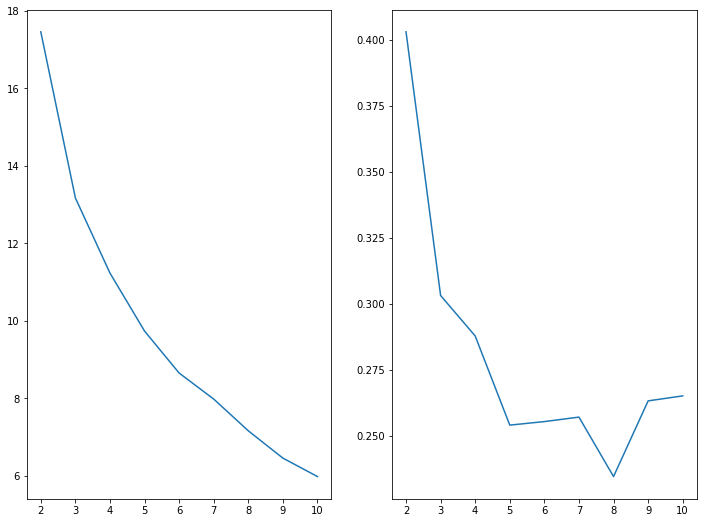

In [498]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,9))
ax1.plot(n_clusters, inertia)
ax2.plot(n_clusters, sscore)
plt.show()

In [511]:
def silhouette_plotsamples(X):
    """ adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    """
    range_n_clusters = [2, 3, 4, 5, 6]

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, ax1 = plt.subplots(figsize=(12, 9))
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, n_init=20)# random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        #ax1.set_yticks([])  # Clear the yaxis labels / ticks
        #ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.403005753994749
For n_clusters = 3 The average silhouette_score is : 0.30360435018340254
For n_clusters = 4 The average silhouette_score is : 0.31022805041101886
For n_clusters = 5 The average silhouette_score is : 0.24506893234423674
For n_clusters = 6 The average silhouette_score is : 0.24830893837915083


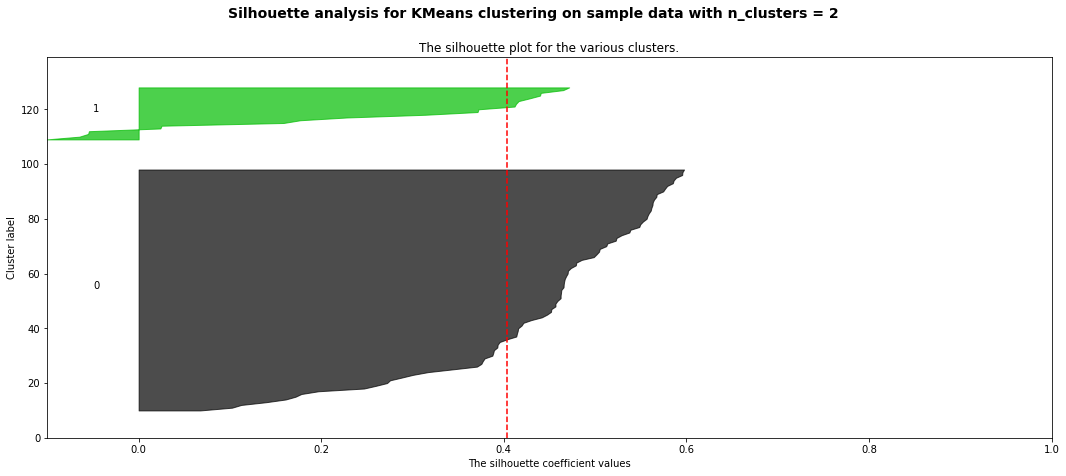

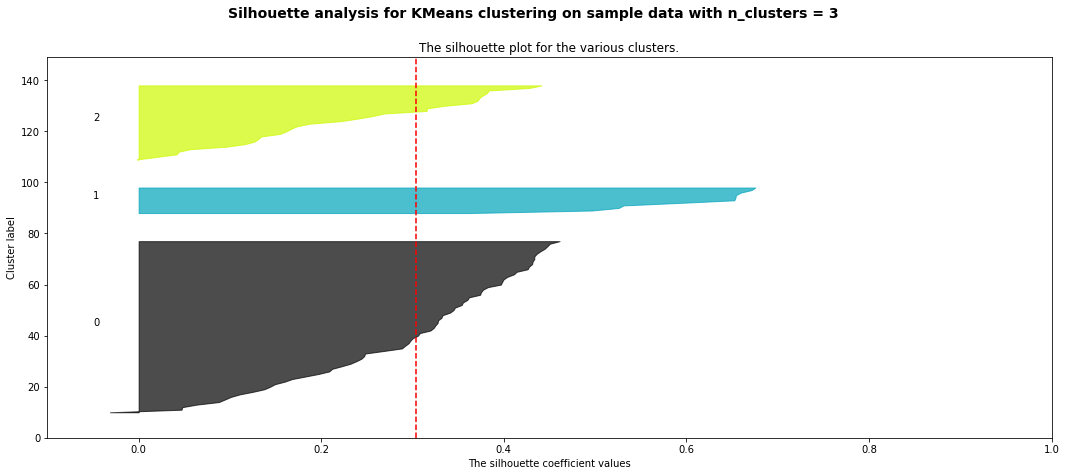

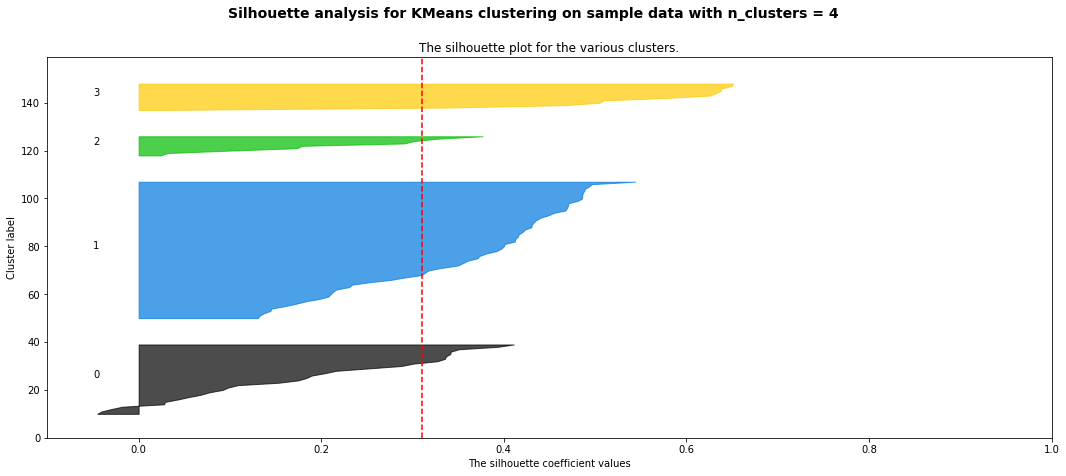

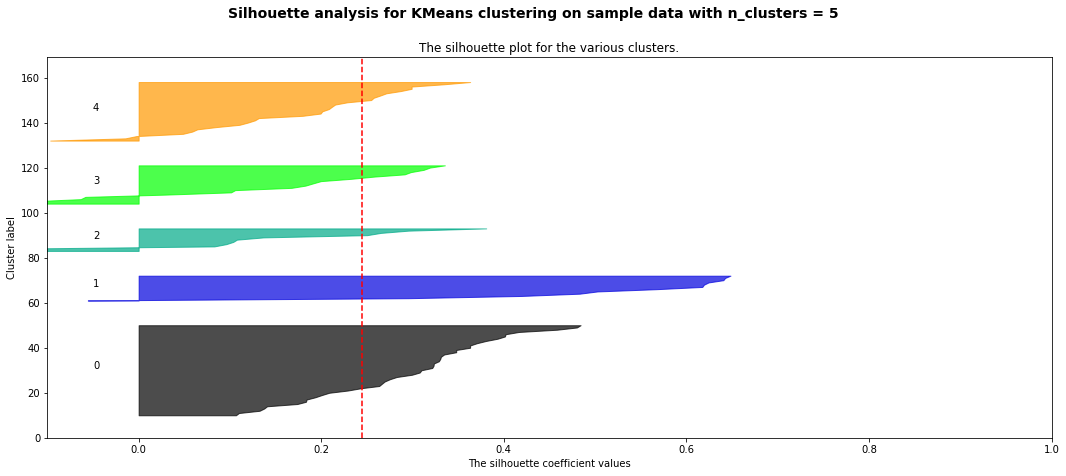

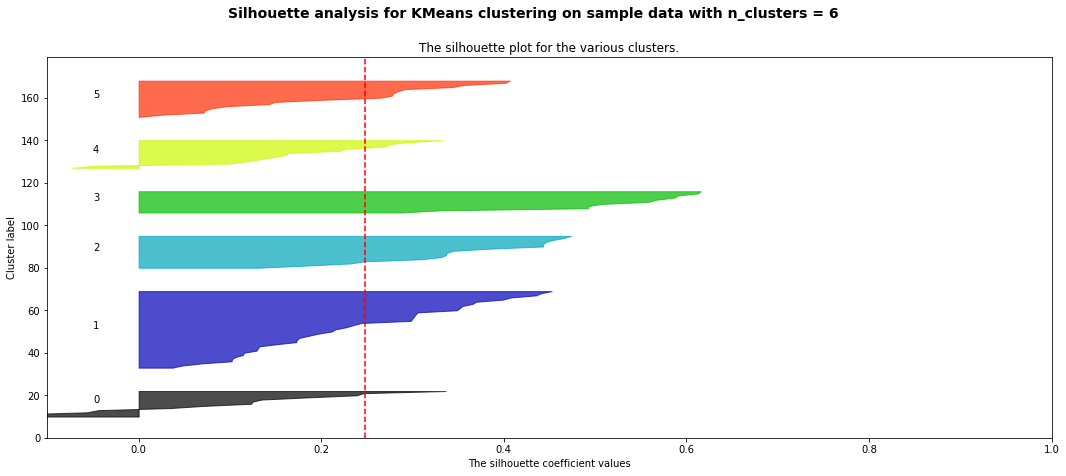

In [512]:
silhouette_plotsamples(X)

From the analysis above the optimal number of clusters is 4

In [513]:
k_means = KMeans(init="k-means++", n_clusters=4, n_init=20)
k_means.fit(usa_final_df.set_index('City'))
k_means_labels = k_means.labels_

In [514]:
usa_clusters_df = usa_final_df.copy()

In [515]:
usa_clusters_df['Cluster'] = k_means_labels

In [516]:
usa_clusters_df

,City,TransportScaledScore,ParksScaledScore,CostScaledScore,HealthScaledScore,WealthScaledScore,TotalScore,Cluster
0,Akron,0.552083,0.624357,0.607235,0.389646,0.209790,1.259188,0
1,Albany,0.843750,0.624357,0.607235,0.710393,0.545455,2.272649,1
2,Albuquerque,0.510417,0.808081,0.965636,0.203192,0.013986,1.887455,3
3,Anchorage,0.364583,0.616162,0.497177,0.328143,0.000000,0.867439,0
4,Appleton,0.406250,0.624357,0.607235,0.281432,0.090909,1.011063,0
...,...,...,...,...,...,...,...,...
104,Tallahassee,0.489583,0.624357,0.607235,0.282600,0.335664,1.190781,0
105,Tampa,0.552083,0.424242,0.679472,0.282600,0.335664,1.138994,0
106,Washington,0.968750,0.979798,0.607235,0.305543,0.027972,2.361354,1
107,West Palm Beach,0.156250,0.624357,0.607235,0.282600,0.335664,0.975503,0


In [517]:
usa_clusters_df = usa_clusters_df.merge(c2_airports_state_df[['Location', 'State', 'Latitude', 'Longitude']].rename(columns={'Location': 'City'}), on='City').copy()

In [518]:
usa_centers = k_means.cluster_centers_

In [519]:
X.shape

(109, 5)

In [520]:
usa_centers.shape

(4, 6)

In [558]:
pprint_all(usa_clusters_df.drop(columns=['State', 'Latitude', 'Longitude']).groupby('Cluster').describe())

In [553]:
usa_clusters_df['Cluster'].value_counts()
#0 Largest cluster: bad transport worst parks worst health worst wealth worst score
#1 similar size with #2. good transport,best parks. Metro life.
#2 expensive, good gdp average best score. California. Outlier. 
#3 second largest: cheap, poor gdp average

0    59
3    27
1    12
2    11
Name: Cluster, dtype: int64

In [565]:
#pprint_all(usa_clusters_df[usa_clusters_df.Cluster==3])

In [566]:
inertia = []
sscore = []
n_clusters = range(2, 11)
X = canada_final_df.drop(columns=['City', 'TotalScore']).values
for i in n_clusters:
    ia, ss = km(X, i)
    inertia.append(ia)
    sscore.append(ss)

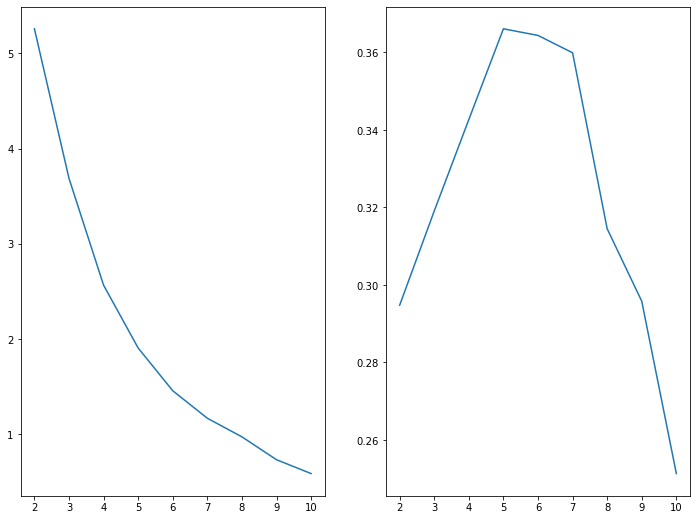

In [567]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,9))
ax1.plot(n_clusters, inertia)
ax2.plot(n_clusters, sscore)
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.2734719325984246
For n_clusters = 3 The average silhouette_score is : 0.21626302388588942
For n_clusters = 4 The average silhouette_score is : 0.27830459653701684
For n_clusters = 5 The average silhouette_score is : 0.30647115050001966
For n_clusters = 6 The average silhouette_score is : 0.2951905812334052


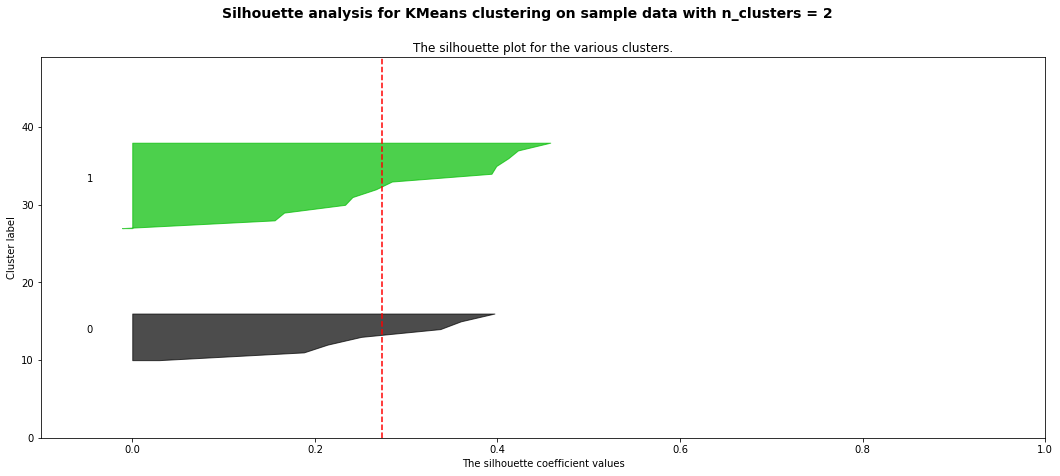

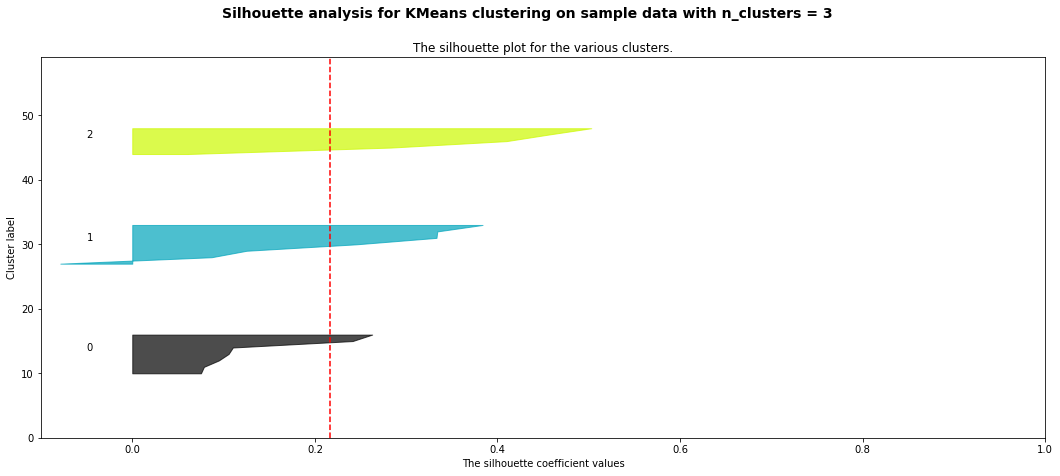

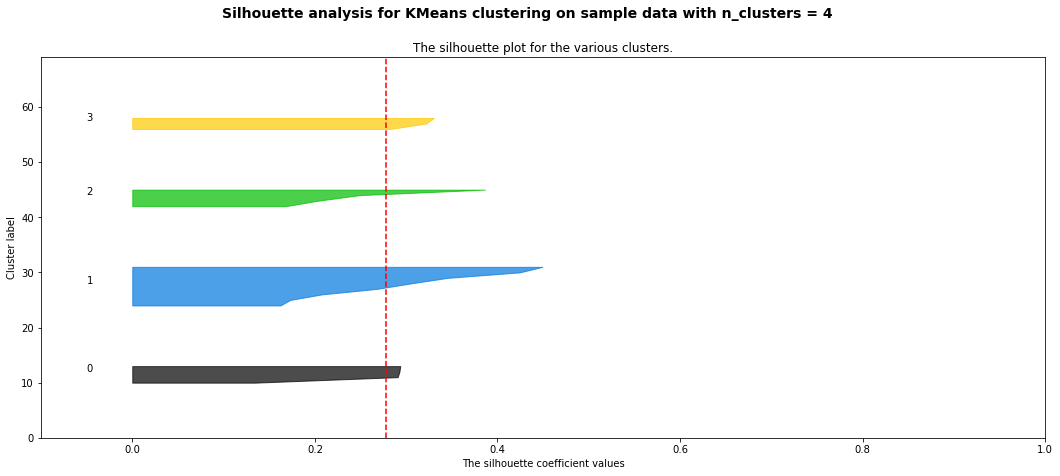

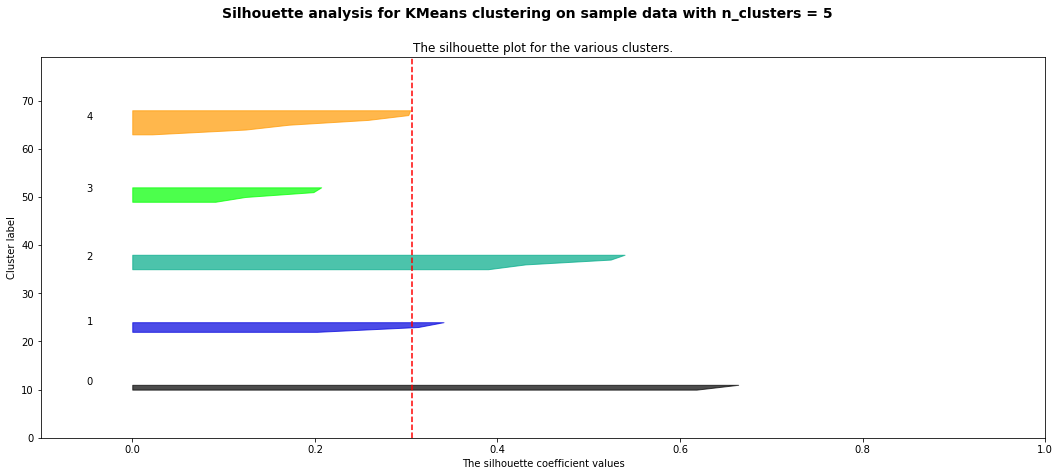

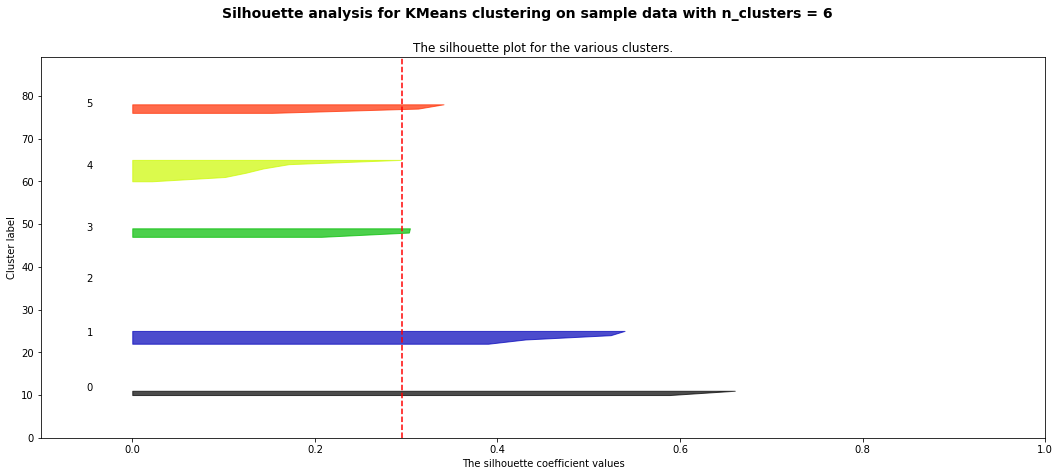

In [568]:
silhouette_plotsamples(canada_final_df.set_index('City'))

The optimal number of clusters is 4.

In [569]:
k_means = KMeans(init="k-means++", n_clusters=4, n_init=20)
k_means.fit(canada_final_df.set_index('City'))
k_means_labels = k_means.labels_

In [570]:
canada_clusters_df = canada_final_df.copy()

In [571]:
canada_clusters_df['Cluster'] = k_means_labels

In [572]:
canada_clusters_df.sort_values(by='Cluster')

,City,TransportScaledScore,ParksScaledScore,CostScaledScore,HealthScaledScore,WealthScaledScore,TotalScore,Cluster
9,Ottawa,0.758308,0.600962,0.407436,0.518365,1.000000,2.370893,0
14,Toronto,1.000000,0.384615,0.000000,0.518365,1.000000,2.416631,0
4,Hamilton,0.640483,0.461538,0.545695,0.518365,1.000000,2.189721,0
6,London,0.537764,0.384615,0.545695,0.518365,1.000000,2.003604,0
16,Victoria,0.921450,0.923077,0.428245,0.814317,0.342098,2.664679,1
15,Vancouver,0.990936,0.538462,0.111034,0.814317,0.342098,2.064368,1
11,Regina,0.921450,0.923077,0.545695,0.069143,0.090862,2.011961,1
10,Quebec,0.700906,0.230769,1.000000,0.654289,0.510804,2.233540,1
0,Calgary,0.876133,0.615385,0.491526,0.700026,0.400156,2.038066,1
3,Halifax,0.332326,0.923077,0.758463,1.000000,0.048165,2.540098,1


In [573]:
canada_clusters_df = canada_clusters_df.merge(c1_airports_province_df[['Location', 'Province', 'Latitude', 'Longitude']].rename(columns={'Location': 'City'}), on='City').copy()

In [574]:
canada_centers = k_means.cluster_centers_

In [576]:
pprint_all(canada_clusters_df.drop(columns=['Province', 'Latitude', 'Longitude']).groupby('Cluster').describe())

In [577]:
canada_clusters_df['Cluster'].value_counts()
#0 bad parks expensive rich 2nd total  
#1 largest cluster: best transport and best parks score 1st
#2 avg  cost and health
#3 cheapest bad health and poorest last

1    9
2    4
0    4
3    2
Name: Cluster, dtype: int64

In [591]:
pprint_all(canada_clusters_df[canada_clusters_df.Cluster==0])

,City,TransportScaledScore,ParksScaledScore,CostScaledScore,HealthScaledScore,WealthScaledScore,TotalScore,Cluster,Province,Latitude,Longitude
4,Hamilton,0.640483,0.461538,0.545695,0.518365,1.0,2.189721,0,Ontario,43.256080,-79.872858
6,London,0.537764,0.384615,0.545695,0.518365,1.0,2.003604,0,Ontario,42.983675,-81.249607
9,Ottawa,0.758308,0.600962,0.407436,0.518365,1.0,2.370893,0,Ontario,45.421106,-75.690308
14,Toronto,1.000000,0.384615,0.000000,0.518365,1.0,2.416631,0,Ontario,43.653482,-79.383935


In [ ]:
#0 Largest cluster: bad transport worst parks worst health worst wealth worst score
#1 similar size with #2. good transport,best parks. Metro life.
#2 expensive, good gdp average best score. California. Outlier. 
#3 second largest: cheap, poor gdp average

- For US cities:
    - Cluster 0 is the largest cluster. Has bad transport score and the worst parks, health, and wealth scores. Has the worst Total Score.
    - Cluster 1 has good transport and best parks.
    - Cluster 2 has all the cities in California. High GDP and best Total Score.
    - Cluster 3 is the second in size. Cheap and poor cities. Average in the rest.
- For Canada:
    - Cluster 0 has bad parks and it is expensive.
    - Cluster 1 is the largest with best transport and parks scores.
    - Cluster 2 is average.
    - Cluster 3 has the lower cost of life and bad health and gdp score.
- The clusters 0 for USA and 3 for Canada present similar characteristics.
- Same for 1 (USA) and 1 (Canada).

We label the cluster as follows,
- USA cluster 0 and Canada cluster 3: Below-average cities.
- USA cluster 1 and Canada cluster 1: Metro cities.
- USA cluster 2: California cities.
- USA cluster 3: Average US cities.
- Canada cluster 0: Ontario cities.
- Canada cluster 2: Average CA cities.

In [592]:
color_palette = ['blue', 'red', 'green', 'cyan'] 
cluster_name = ['Below-average', 'Metro', 'California', 'Average US']
fig = folium.Figure(width=1000, height=500)

map_cluster = folium.Map(location=[latitude, longitude], zoom_start=3, no_touch=False).add_to(fig)

plugins.ScrollZoomToggler().add_to(map_cluster_usa)
# add markers to map
for lat, lng, city, cluster in zip(usa_clusters_df['Latitude'], 
                                   usa_clusters_df['Longitude'], 
                                   usa_clusters_df['City'],
                                   usa_clusters_df['Cluster']):
    label = '{}'.format(cluster_name[cluster])
    label = folium.Popup(label, parse_html=True)
    color = color_palette[cluster]
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.5,
        parse_html=False).add_to(map_cluster)  

color_palette = ['yellow', 'red', 'magenta', 'blue']
cluster_name = ['Ontario', 'Metro', 'Average CA', 'Below-average']
for lat, lng, city, cluster in zip(canada_clusters_df['Latitude'], 
                                   canada_clusters_df['Longitude'], 
                                   canada_clusters_df['City'],
                                   canada_clusters_df['Cluster']):
    label = '{}'.format(cluster_name[cluster])
    label = folium.Popup(label, parse_html=True)
    color = color_palette[cluster]
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.5,
        parse_html=False).add_to(map_cluster)
map_cluster

In [628]:
count = 0
count2 = 0
for d, cities in enumerate(city_simil):
    #print(cities)
    # https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
    indices = np.argpartition(cities, -3)[-3:]
    indices = indices[np.argsort(cities[indices])][::-1]
    us_cluster = usa_clusters_df.iloc[d]['Cluster']
    ca_cities = list(canada_clusters_df.iloc[indices]['City'])
    ca_clusters  = list(canada_clusters_df.iloc[indices]['Cluster'])
    print('From {}({}) to '.format(usa_clusters_df.iloc[d]['City'], us_cluster), end='')
    for c, cl in zip(ca_cities, ca_clusters):
        print('{}({}),'.format(c, cl), end=' ')
    if (us_cluster == 0 and ca_clusters[0] == 3) or (us_cluster == 1 and ca_clusters[0] == 1):
        count +=1
    if (us_cluster == 1 and ca_clusters[0] == 1):
        count2 +=1
    print()

From Akron(0) to Montreal(1), Edmonton(1), Winnipeg(1), 
From Albany(1) to Calgary(1), Edmonton(1), Montreal(1), 
From Albuquerque(3) to Whitehorse(3), Saskatoon(3), Winnipeg(1), 
From Anchorage(0) to Winnipeg(1), Moncton(2), Halifax(1), 
From Appleton(0) to Winnipeg(1), Saskatoon(3), Whitehorse(3), 
From Atlanta(3) to Saskatoon(3), Winnipeg(1), Regina(1), 
From Atlantic City(3) to Winnipeg(1), Montreal(1), Edmonton(1), 
From Austin(0) to Hamilton(0), London(0), Ottawa(0), 
From Baltimore(1) to Victoria(1), Edmonton(1), Calgary(1), 
From Bangor(0) to Halifax(1), Gander(2), Moncton(2), 
From Birmingham(0) to Moncton(2), Whitehorse(3), Halifax(1), 
From Boise(0) to Whitehorse(3), Saskatoon(3), Winnipeg(1), 
From Boston(1) to Victoria(1), Vancouver(1), Calgary(1), 
From Bradenton(0) to Montreal(1), Edmonton(1), Winnipeg(1), 
From Buffalo(1) to Edmonton(1), Montreal(1), Calgary(1), 
From Charleston(0) to Whitehorse(3), Saskatoon(3), Winnipeg(1), 
From Charlotte(0) to Winnipeg(1), Saskatoon

In [629]:
count

23

In [630]:
tcount = len(usa_clusters_df[(usa_clusters_df.Cluster==0) | (usa_clusters_df.Cluster==1)])

In [631]:
100*count/tcount

32.394366197183096

In [632]:
tcount2 = len(usa_clusters_df[(usa_clusters_df.Cluster==1)])
100*count2/tcount2ca

91.66666666666667

## Neighborhood segmentation for origin and destination cities

This is a mock test, because we need to do the recommendation analysis before doing the clustering.

Let's assume that the destination city is Montreal (CA), and the city of origin is Akron (USA).

Foursquare API
 * 99 regular calls per day
 
 1. Regular: Search for a specific type of venue around a given location.
 
 2. Premium: learn more about a specific venue
 
 3. Regular: learn about a user.
 
 4. Regular: explore a given location.
 
 5. Regular: explore trending venues around a given location.

http://api.foursquare.com/v2/tips

venues

users 

tips

In [ ]:
# load environment variables
import os
from dotenv import load_dotenv
load_dotenv()

In [ ]:
# get foursquare key
CLIENT_ID = os.getenv('FOURSQUARE_CLIENT_ID')# your Foursquare ID
CLIENT_SECRET = os.getenv('FOURSQUARE_CLIENT_SECRET')# your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [ ]:
# get bing api key
bing_api_key = os.environ.get('BING_API_KEY')

In [ ]:
c1_airports_df.Location[9].strip()

In [ ]:
# regular expressions
import re

In [ ]:
def clean_city(city):
    """ Remove parenthesis and text between from city
    """
    city = re.sub("[\(\[].*?[\)\]]", "", city)
    return city.replace(" ", "") 

In [ ]:
# apply function to each city
c1_airports_df.Location = c1_airports_df.Location.apply(clean_city)

In [ ]:
c1_airports_df = c1_airports_df.rename(columns={'Location': 'City'})

In [ ]:
dest_city = c1_airports_df.City[9]

In [ ]:
print(dest_city)

In [ ]:
# find postal codes
URL = 'https://worldpostalcode.com/canada/quebec/' + dest_city.lower()
page = requests.get(URL)

Load the content with `BeautifulSoup`

In [ ]:
soup = BeautifulSoup(page.content, 'html.parser')

The table to scrape is identified by `class="codes"`

In [ ]:
table = soup.find(class_="codes")

Parse the table

In [ ]:
places = table.find_all(class_ = 'place')
codes = table.find_all(class_ = 'code')
#print(places)
data = []
for place, code in zip(places, codes):
    data.append((place.string, code.string))

Load the table into a dataframe

In [ ]:
data

In [ ]:
data = pd.DataFrame(data, columns=['Borough', 'PostalCode'])

In [ ]:
data

Check for repetitions for `PostalCode`

### Geolocation data by bing!

In [ ]:
import geocoder

Use geocoder and bing to obtain the coordinates for each postal code

In [ ]:
coords = []
for i in data.index:
    postal_code = data.at[i, 'PostalCode']

    lat_lng_coords = None

    g = []
    while(not g):
        g = geocoder.bing(location=dest_city, postalCode='{}'.format(postal_code), method='details', key=bing_api_key)
        
    
    lat_lng_coords = g.latlng

    coords.append([lat_lng_coords[0], lat_lng_coords[1]])

In [ ]:
dest_city_data = pd.concat([data, pd.DataFrame(coords)], axis=1).sort_values(by='PostalCode').reset_index(drop=True)

In [ ]:
dest_city_data.rename(columns={0: 'Latitude', 1: 'Longitude'}, inplace=True)

Table with coordinates retrieved using bing

In [ ]:
dest_city_data.to_clipboard(sep=',')

In [ ]:
import folium
import json

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium # map rendering library

In [ ]:
address = dest_city+','+country1

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

In [ ]:

map_dest_city = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(dest_city_data['Latitude'], 
                             dest_city_data['Longitude'], 
                             dest_city_data['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dest_city)  
    
map_dest_city

In [ ]:
# to save a PNG of the map
import io
from PIL import Image

In [ ]:
img_data = map_dest_city._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('map_dest_city.png')

![image](map_dest_city.png)

In [ ]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Explore Neighborhoods

#### Use the same function of previous Lab

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Run the function

In [ ]:
LIMIT = 100
radius = 500
dest_city_venues = getNearbyVenues(names=dest_city_data['Borough'],
                                   latitudes=dest_city_data['Latitude'],
                                   longitudes=dest_city_data['Longitude']
                                  )



#### Let's check the results

In [ ]:
print(dest_city_venues.shape)
dest_city_venues.head()

Let's check how many venues were returned for each neighborhood

In [ ]:
dest_city_venues.groupby('Neighborhood').count()

#### Let's find out how many unique categories can be curated from all the returned venues

In [ ]:
print('There are {} uniques categories.'.format(len(dest_city_venues['Venue Category'].unique())))

# Data description and methods

From the tables above, we will extract the following features:

- We will focus in the destination cities which have a nearby airport.
- With the origin address and country destination we will determine the most appropiated cities to migrate.
- We will use postal code information to get the borough of the destination cities.
- We will use bing to get the coordinates of the boroughs.
- We will use follium to display the map and the boroughs.
- We will use foursquare API to get the most popular venues in destination and origin cities.
- We will use k-means clustering to cluster the boroughs with common features.
- We will determine the similarity between the borough of origin and each cluster in the city of destination, usign a recommendation engine.